<a href="https://colab.research.google.com/github/PosgradoMNA/TC5035.10.Equipo6/blob/main/Avance4_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

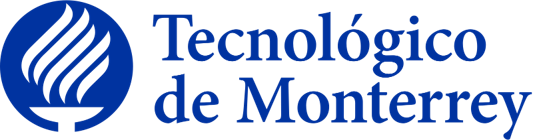

---
# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### **Desarrollo de un Sistema de Visión mediante OpenCV para el Aseguramiento de la Calidad Final de Motores para Aplicaciones Robóticas**
### Profesora Titular: Dra. Grettel Barceló Alonso
### Profesor Titular: Dr. Luis Eduardo Falcón Morales
### Profesor Tutor: María De La Paz Rico Fernández
### Actividad: Avance 3 - Baseline
###Alumnos:
* A01793672 - Freddy Armendariz Herrera
* A01793668 - Samuel Elías Flores González
* A01793814 - Emerson Jonathan Rincón Morales
---

---
## **Entendimiento de los Datos**

### **Recolección de Datos Iniciales**

#### ***Importación de Librerías***

In [1]:
# Descargar Data Set
# ====================================================================
import glob

# Manipulación y Tratamiento de Datos
# ====================================================================
import pandas as pd
import numpy as np

# Gráficos
# ====================================================================
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de Imágenes
# ====================================================================
import cv2
from google.colab.patches import cv2_imshow
import os
from skimage.feature import hog

# Preprocesado y Modelado
# ====================================================================
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Escalamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, Normalizer, RobustScaler, MaxAbsScaler

# Clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, Lasso

# Evaluacion
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Creación de lista con la ruta de cada imagen en el Dataset
okmotor = glob.glob('/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/Imagenes/Motor/Good/*.jpg')
nokmotor = glob.glob('/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/Imagenes/Motor/Bad/*.jpg')

### **Descripción de los Datos**

In [4]:
#Definir funcion para mostar imagen
def ShowImages(pictures,titles,x,y):

  qty = len(pictures)                                          #qty = Cantidad de imagenes en la lista de imagenes
  fig = plt.figure(figsize=(x, y))                             #fig = crea figura con dimension x, y

  #Itera las imagenes y los titulos para anexarlos a figura
  for i, (img,tit) in enumerate(zip(pictures,titles)):
    a = fig.add_subplot(1,qty,i+1)                             #a = Agrega subplot
    if len(img.shape) == 2:  # Imagen en escala de grises
      imgplot = plt.imshow(img, cmap='gray')
    else:  # Imagen RGB
      imgplot = plt.imshow(img)
    a.set_title(tit)                                           #Establece titulo

  #Muestra figura con imagenes y titulos
  plt.show()

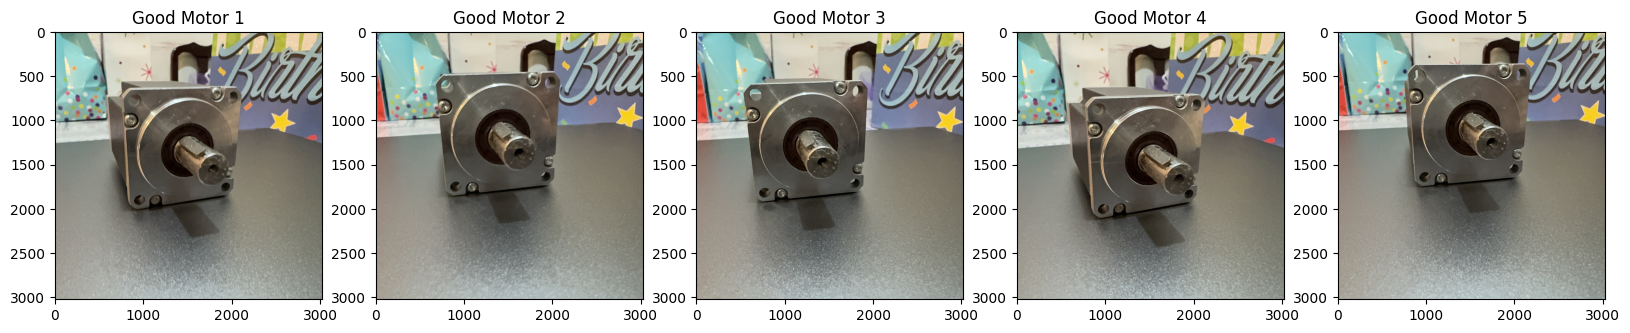

In [5]:
pics = []
tits = []

for i in range(5):
  i1 = cv2.imread(okmotor[i], cv2.IMREAD_COLOR)
  im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2RGB)
  pics.append(im1)
  tits.append('Good Motor %d'%(i+1))

ShowImages(pics,tits,20,16)

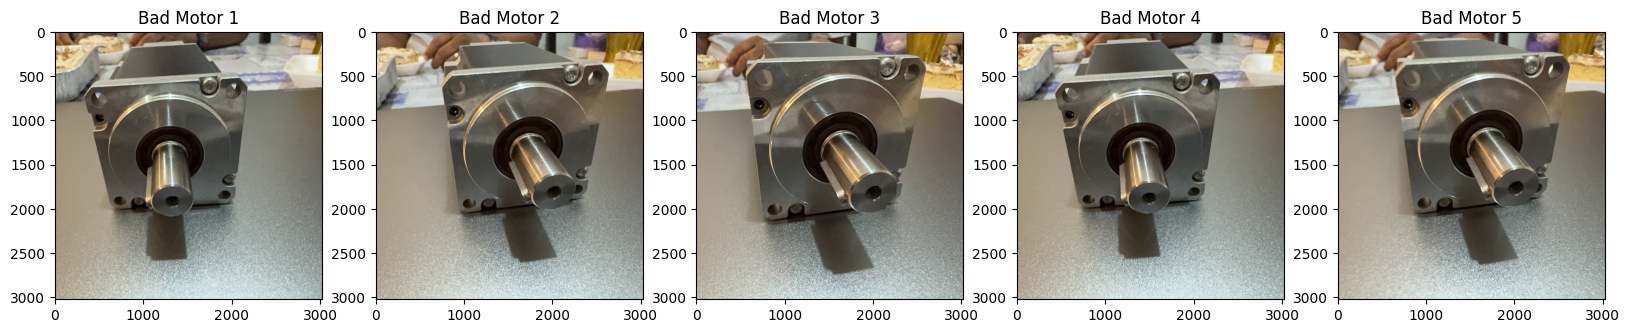

In [6]:
pics = []
tits = []

for i in range(5):
  i1 = cv2.imread(nokmotor[i], cv2.IMREAD_COLOR)
  im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2RGB)
  pics.append(im1)
  tits.append('Bad Motor %d'%(i+1))

ShowImages(pics,tits,20,16)

En las imágenes se aprecia como el conjunto de datos es conformado por imágenes de la cara frontal de un motor, tomadas desde diferentes ángulos y perspectivas, en donde las clases son dos: motor malo y motor bueno. Los malos son aquellos en donde al frame le hace falta alguno o varios de los tornillos, mientras que el motor bueno se encuentra completo.

### **Exploración de los Datos**

Dado que el conjunto de datos son imágenes, no se puede trabajar directamente con ellas para trabajar con algún modelo. Por lo que se requiere hacer una extracción de características de las imágenes y así poder trabajar con datos estructurados.

#### ***Lectura de Datasets - Extracción de Features de Imagenes con HOG***

In [7]:
# Definición de función para extracción de características con Histograma de Gradientes
def HOGFeatures(pictures, width=64, height=64):
  vehicle_hog_accum = []
  vehicle_hog_imgs = []
  new_size = (width, height)
  for i in pictures:
    #img_color = mpimg.imread(i)
    #img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_gray = cv2.imread(i,0)
    img_resized = cv2.resize(img_gray, new_size)
    #img_color = cv2.imread(i, cv2.IMREAD_COLOR)
    #img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    vehicle_hog_feature, vehicle_hog_img = hog(img_resized,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),#16*16
                                               cells_per_block = (2,2),#2*2
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    vehicle_hog_accum.append(vehicle_hog_feature)
    vehicle_hog_imgs.append(vehicle_hog_img)

  return vehicle_hog_accum, vehicle_hog_imgs

In [8]:
okmotors, okmotors_imgs = HOGFeatures(okmotor)

In [9]:
X_okmotors = np.vstack(okmotors).astype(np.float64)
y_okmotors = np.ones(len(X_okmotors))
print('Tamaño de X_okmotors:',X_okmotors.shape)
print('Tamaño de y_okmotors:',y_okmotors.shape)

Tamaño de X_okmotors: (521, 396)
Tamaño de y_okmotors: (521,)


In [10]:
nokmotors, nokmotors_imgs = HOGFeatures(nokmotor)

In [11]:
X_nokmotors = np.vstack(nokmotors).astype(np.float64)
y_nokmotors = np.zeros(len(X_nokmotors))
print('Tamaño de X_nokmotors:',X_nokmotors.shape)
print('Tamaño de y_nokmotors:',y_nokmotors.shape)

Tamaño de X_nokmotors: (502, 396)
Tamaño de y_nokmotors: (502,)


In [12]:
# Combinación de conjuntos positivo y negativo
X = np.vstack((X_okmotors, X_nokmotors))
y = np.hstack((y_okmotors, y_nokmotors))
print('Tamaño de X: ',X.shape)
print('Tamaño de y: ',y.shape)

Tamaño de X:  (1023, 396)
Tamaño de y:  (1023,)


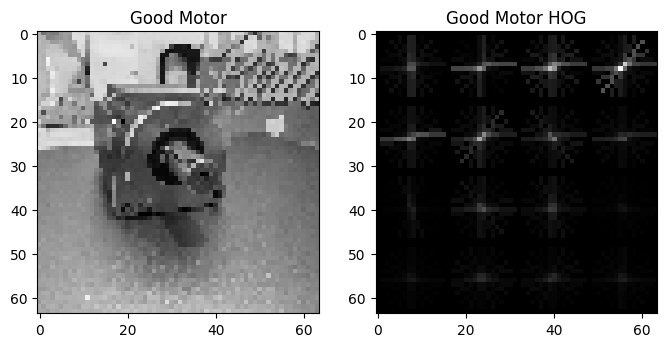

In [13]:
pics = []
tits = []

i1 = cv2.imread(okmotor[0], cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2GRAY)
new_size = (64, 64)
im1_resized = cv2.resize(im1, new_size)
pics.append(im1_resized)
tits.append('Good Motor')
pics.append(okmotors_imgs[0])
tits.append('Good Motor HOG')

ShowImages(pics,tits,8,8)

En las imágenes comparadas en el gráfico anterior, se muestra una de las imágenes a la que se le redujeron sus dimensiones y a la derecha la visualización del histograma de gradientes de la misma imagen.
Una vez teniendo el histograma de gradientes de cada imagen, se procede a trabajar sobre el dataframe que los contiene.

In [14]:
# Creación de DataFrame
df = pd.DataFrame(X)
df.head()

0         1         2         3         4         5         6    \
0  0.254142  0.045962  0.146472  0.099399  0.074725  0.152968  0.039518   
1  0.251936  0.093208  0.068914  0.096173  0.053517  0.131456  0.078511   
2  0.240471  0.087092  0.131441  0.062676  0.036507  0.186460  0.056002   
3  0.262344  0.057915  0.058948  0.044376  0.060529  0.167414  0.048964   
4  0.251276  0.117453  0.066621  0.056287  0.059906  0.131531  0.089834   

        7         8         9    ...       386       387       388       389  \
0  0.075118  0.116912  0.100536  ...  0.061775  0.034582  0.086003  0.092566   
1  0.092607  0.099691  0.128919  ...  0.083612  0.109859  0.124805  0.126216   
2  0.078076  0.151267  0.100257  ...  0.038327  0.104213  0.075911  0.156987   
3  0.114271  0.123804  0.107881  ...  0.075013  0.077889  0.088727  0.081806   
4  0.146850  0.116628  0.081358  ...  0.150022  0.088644  0.169590  0.125047   

        390       391       392       393       394       395  
0  0.193060  0.106113  0.106467  0.139731  0.093035  0.120283  
1  0.085778  0.158204  0.103753  0.090662  0.129393  0.119916  
2  0.166736  0.193317  0.154253  0.186027  0.191794  0.126947  
3  0.140347  0.100269  0.067425  0.162521  0.109433  0.088335  
4  0.166791  0.093865  0.140944  0.104777  0.121789  0.092693  

[5 rows x 396 columns]

In [15]:
# Cambio de nombre a las columnas
header = []

for i in range(X.shape[1]):
  x = i+1
  header.append("X%d"%x)

df.columns = header

# Se agrega "y" al dataframe
df['Label'] = y

# Mostrar DataFrame
df.head()

X1        X2        X3        X4        X5        X6        X7  \
0  0.254142  0.045962  0.146472  0.099399  0.074725  0.152968  0.039518   
1  0.251936  0.093208  0.068914  0.096173  0.053517  0.131456  0.078511   
2  0.240471  0.087092  0.131441  0.062676  0.036507  0.186460  0.056002   
3  0.262344  0.057915  0.058948  0.044376  0.060529  0.167414  0.048964   
4  0.251276  0.117453  0.066621  0.056287  0.059906  0.131531  0.089834   

         X8        X9       X10  ...      X388      X389      X390      X391  \
0  0.075118  0.116912  0.100536  ...  0.034582  0.086003  0.092566  0.193060   
1  0.092607  0.099691  0.128919  ...  0.109859  0.124805  0.126216  0.085778   
2  0.078076  0.151267  0.100257  ...  0.104213  0.075911  0.156987  0.166736   
3  0.114271  0.123804  0.107881  ...  0.077889  0.088727  0.081806  0.140347   
4  0.146850  0.116628  0.081358  ...  0.088644  0.169590  0.125047  0.166791   

       X392      X393      X394      X395      X396  Label  
0  0.106113  0.106467  0.139731  0.093035  0.120283    1.0  
1  0.158204  0.103753  0.090662  0.129393  0.119916    1.0  
2  0.193317  0.154253  0.186027  0.191794  0.126947    1.0  
3  0.100269  0.067425  0.162521  0.109433  0.088335    1.0  
4  0.093865  0.140944  0.104777  0.121789  0.092693    1.0  

[5 rows x 397 columns]

### **Verificación de Calidad de los Datos**

In [16]:
df.shape

(1023, 397)

In [17]:
df.dtypes

X1       float64
X2       float64
X3       float64
X4       float64
X5       float64
          ...   
X393     float64
X394     float64
X395     float64
X396     float64
Label    float64
Length: 397, dtype: object

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 397 entries, X1 to Label
dtypes: float64(397)
memory usage: 3.1 MB


In [19]:
df.isna().values.any()     #True = Si hay valores nulos

False

---
## **Preparación de los Datos**

### **Preprocesamiento / Limpieza**

In [20]:
df.describe()

X1           X2           X3           X4           X5  \
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000   
mean      0.204273     0.116602     0.159195     0.124285     0.127285   
std       0.047379     0.049815     0.060320     0.052402     0.052806   
min       0.045686     0.010785     0.026334     0.006624     0.013380   
25%       0.174465     0.078205     0.110854     0.086747     0.086823   
50%       0.223390     0.114464     0.155405     0.117153     0.123782   
75%       0.237333     0.148419     0.208725     0.158094     0.157565   
max       0.293715     0.259603     0.328637     0.264424     0.291959   

                X6           X7           X8           X9          X10  ...  \
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000  ...   
mean      0.225696     0.131780     0.112858     0.114074     0.099224  ...   
std       0.050756     0.050743     0.049347     0.050369     0.045442  ...   
min       0.035889     0.016048     0.010946     0.006554     0.003082  ...   
25%       0.199937     0.095428     0.076591     0.076109     0.067452  ...   
50%       0.234014     0.128149     0.108134     0.109460     0.091713  ...   
75%       0.255078     0.163895     0.144506     0.144646     0.126458  ...   
max       0.355962     0.271380     0.262073     0.261335     0.241677  ...   

              X388         X389         X390         X391         X392  \
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000   
mean      0.085498     0.086320     0.098702     0.159759     0.116095   
std       0.031152     0.030872     0.034974     0.039875     0.037222   
min       0.017425     0.024558     0.017441     0.037703     0.026467   
25%       0.063153     0.064214     0.073930     0.130551     0.089122   
50%       0.081012     0.082127     0.095333     0.159613     0.114386   
75%       0.102012     0.102467     0.118248     0.191178     0.138363   
max       0.247273     0.219718     0.220906     0.245226     0.226939   

              X393         X394         X395         X396        Label  
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000  
mean      0.110643     0.114181     0.118352     0.112429     0.509286  
std       0.037249     0.038045     0.037391     0.036283     0.500158  
min       0.022573     0.027057     0.029780     0.037449     0.000000  
25%       0.083380     0.087073     0.091509     0.086945     0.000000  
50%       0.108685     0.109680     0.115139     0.108904     1.000000  
75%       0.134418     0.135370     0.141168     0.133594     1.000000  
max       0.232910     0.234355     0.222242     0.240025     1.000000  

[8 rows x 397 columns]

Dado que las características del DataFrame fueron extraídas de imágenes utilizando histograma de gradientes, se pueden hacer las siguientes observaciones:
* No existe sesgamiento
* No hay datos nulos
* Solo existen variables númericas y no categóricas
* El rango de los datos en las columnas luce similar.

### **Selección de Características**

<Axes: >

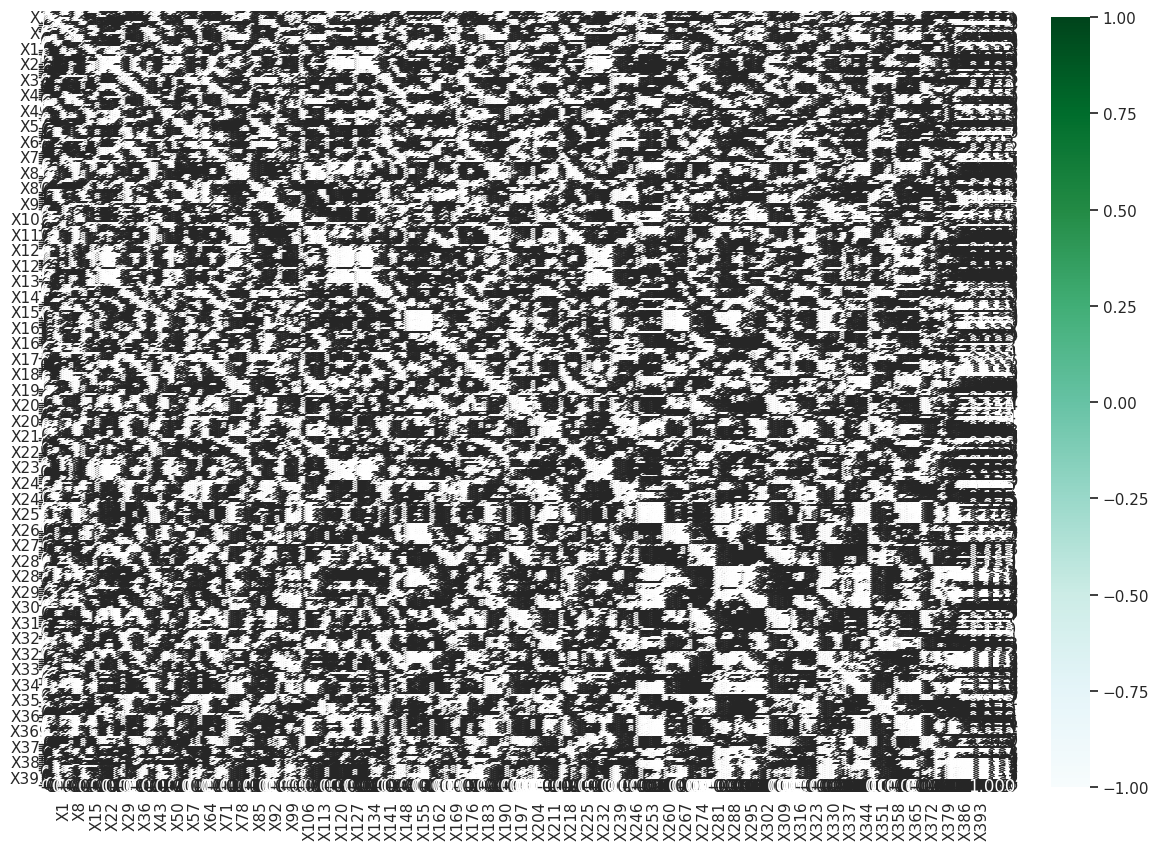

In [21]:
# Se visualiza la matriz de correlacion
corrs = df.corr()
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corrs, vmin = -1, vmax = 1, cmap = "BuGn", annot= True, fmt=".3f")

Dado que se tienen un total de 393 características, resulta casi imposible analizar la correlación entre las características y la etiqueta.

In [22]:
# Separación de Variables de Entrada y Salida
Xdf = df.drop("Label", axis=1)
Ydf = df["Label"]

In [23]:
Xdf.head()

X1        X2        X3        X4        X5        X6        X7  \
0  0.254142  0.045962  0.146472  0.099399  0.074725  0.152968  0.039518   
1  0.251936  0.093208  0.068914  0.096173  0.053517  0.131456  0.078511   
2  0.240471  0.087092  0.131441  0.062676  0.036507  0.186460  0.056002   
3  0.262344  0.057915  0.058948  0.044376  0.060529  0.167414  0.048964   
4  0.251276  0.117453  0.066621  0.056287  0.059906  0.131531  0.089834   

         X8        X9       X10  ...      X387      X388      X389      X390  \
0  0.075118  0.116912  0.100536  ...  0.061775  0.034582  0.086003  0.092566   
1  0.092607  0.099691  0.128919  ...  0.083612  0.109859  0.124805  0.126216   
2  0.078076  0.151267  0.100257  ...  0.038327  0.104213  0.075911  0.156987   
3  0.114271  0.123804  0.107881  ...  0.075013  0.077889  0.088727  0.081806   
4  0.146850  0.116628  0.081358  ...  0.150022  0.088644  0.169590  0.125047   

       X391      X392      X393      X394      X395      X396  
0  0.193060  0.106113  0.106467  0.139731  0.093035  0.120283  
1  0.085778  0.158204  0.103753  0.090662  0.129393  0.119916  
2  0.166736  0.193317  0.154253  0.186027  0.191794  0.126947  
3  0.140347  0.100269  0.067425  0.162521  0.109433  0.088335  
4  0.166791  0.093865  0.140944  0.104777  0.121789  0.092693  

[5 rows x 396 columns]

Todas las variables son númericas, por lo que no se pueden eliminar variables categóricas.

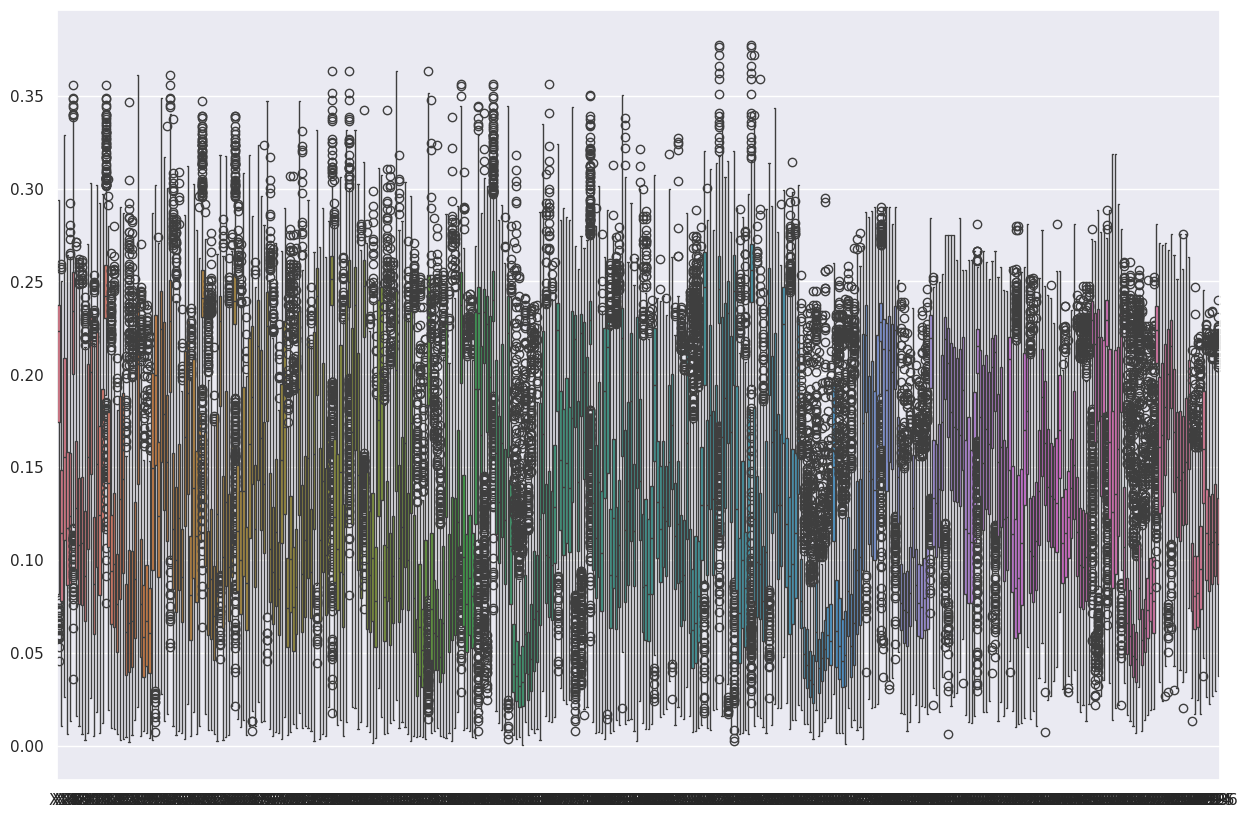

In [24]:
# Grafico de cajas
sns.boxplot(data = Xdf, orient="v")
plt.show()

A pesar de que todos los datos se encuentran en un rango similar, el grafico de cajas demuetra que las cajas estan distribuidas en diferentes rangos, es decir, el 50% de los datos en cada columna se distribuye de distinta manera, por ello mismo los bigotes también tienen diferente longitud y posición, además de que se tienen demasiados outliers.

In [25]:
# Exploracion de la varianza
print('Varianza correspondiente a cada columna:')
print(Xdf.var())
print('\nTotal de varianza: ',sum(Xdf.var()))
print('\nProporcion de varianza de cada columna:')
print(np.round(Xdf.var()/sum(Xdf.var()),3)*100)

Varianza correspondiente a cada columna:
X1      0.002245
X2      0.002481
X3      0.003639
X4      0.002746
X5      0.002788
          ...   
X392    0.001385
X393    0.001387
X394    0.001447
X395    0.001398
X396    0.001316
Length: 396, dtype: float64

Total de varianza:  1.0263399625851835

Proporcion de varianza de cada columna:
X1      0.2
X2      0.2
X3      0.4
X4      0.3
X5      0.3
       ... 
X392    0.1
X393    0.1
X394    0.1
X395    0.1
X396    0.1
Length: 396, dtype: float64


Segun su estadistica descriptiva y varianza, se aprecia como los valores entre columnas tienen similares escalas numericas, lo cual produce un bajo indice de varianza. Esto es resultado de tener magnitudes similares en todas las columnas.
Cabe recalcar que al ser un número elevado de características, cada uno de ellas tiene una parte de varianza.

### **Escalamiento de Características**

Los rangos y magnitudes entre columnas son similares, pero si distribución no es igual, por lo que se procede a aplicar una normalización estándar en todas las columnas.

In [26]:
# Normalizar los datos
scaler = StandardScaler()
Xdf_scaled = scaler.fit_transform(Xdf)

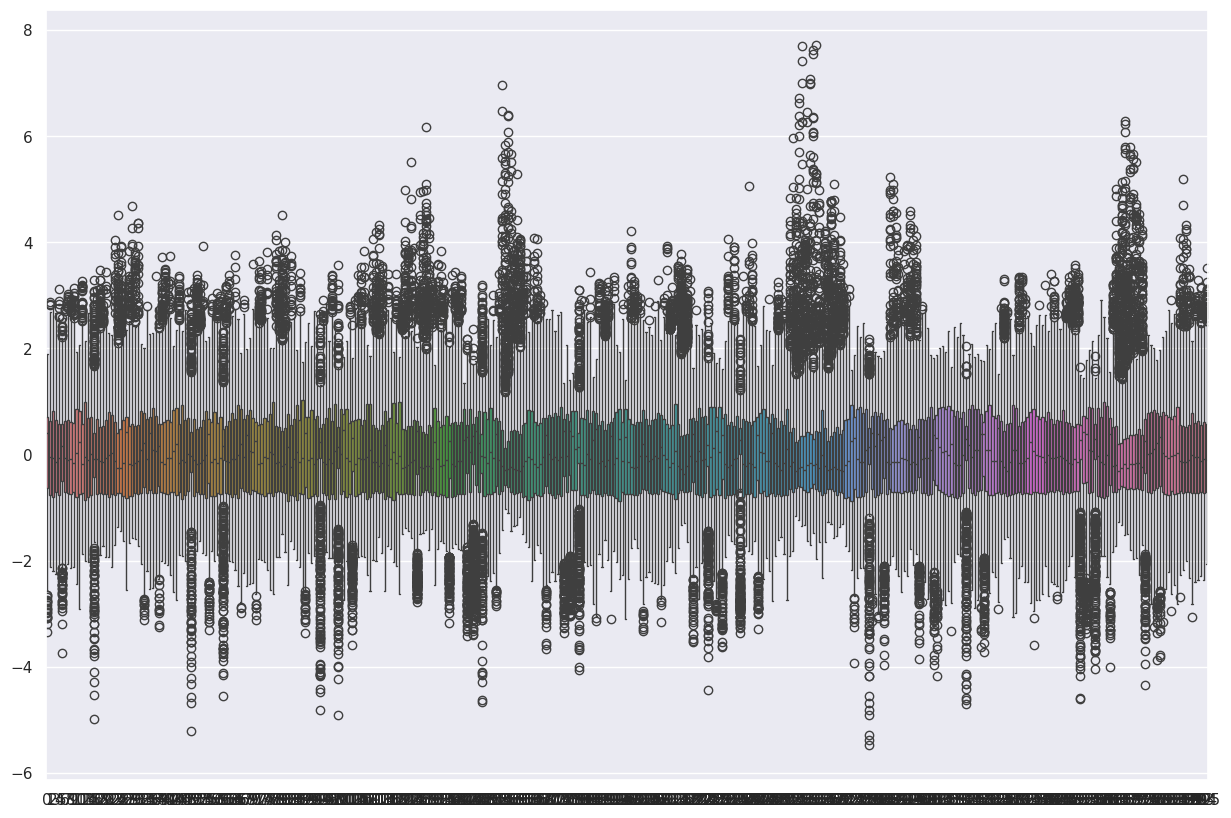

In [27]:
# Grafico de cajas
sns.boxplot(data = Xdf_scaled, orient="v")
plt.show()

A pesar de que los outliers no desaparecieron, se aprecia como las cajas y bigotes se emparejaron en el mismo rango.

### **Balanceo de Clases**

In [28]:
print('Total de datos generados:', Ydf.shape[0])
print('Total de datos en la clase positiva', Ydf.sum())
print('Total de datos en la clase negativa', (Ydf.shape[0] - Ydf.sum()))

Total de datos generados: 1023
Total de datos en la clase positiva 521.0
Total de datos en la clase negativa 502.0


Las clases tienen una cantidad similar de datos por lo que se consideran balanceadas.

### **Construcción de Características**

Nuestro conjunto de datos tiene demasiadas dimensiones o características, lo que puede caer en un aumento del espacio de los datos haciendo que los datos se vuelvan dispersos y por ende dificultar la identificación de patrones significativos. También puede provocar overfitting en los modelos al ajustar demasiado a los datos de entrenamiento, reduciendo así la capacidad de generalizar nuevos datos. Además, aumenta el tiempo de entrenamiento de modelos.

Debido a lo anterior se procede a aplicar una reducción de dimensionalidad con PCA.

#### ***Reducción de Dimensiones con PCA***

**Paso 1: Estandarización de los Datos**

Antes de aplicar PCA, es importante estandarizar los datos. Esto implica escalar las características para que tengan una media de 0 y una desviación estándar de 1. La estandarización asegura que todas las características contribuyan de manera equitativa al análisis.

**Paso 2: Cálculo de la Matriz de Covarianza**

La matriz de covarianza describe la variabilidad conjunta de las características en el conjunto de datos. Esta matriz es crucial para PCA ya que se utiliza para identificar las direcciones de máxima varianza.

**Paso 3: Cálculo de los Vectores y Valores Propios**

Los vectores propios (o eigenvectors) y los valores propios (o eigenvalues) de la matriz de covarianza se calculan para identificar las direcciones principales de varianza (componentes principales).

**Paso 4: Selección de Componentes Principales**

Ordena los valores propios de mayor a menor y selecciona los primeros 'k' componentes principales que expliquen la mayor parte de la varianza en los datos. El número de componentes 'k' puede ser determinado por la varianza explicada acumulativa.

**Paso 5: Proyección a Subespacio de Menor Dimensión**

Proyecta los datos originales a los nuevos ejes definidos por los componentes principales seleccionados.

**Paso 6 (Opcional): Uso de Librerías de Python (e.g., Scikit-Learn)**

Para simplificar el proceso, puedes usar librerías como Scikit-Learn que tienen implementaciones optimizadas de PCA.

**Paso 7: Interpretación de los Resultados**

Finalmente, interpreta los resultados obtenidos. Las nuevas características (componentes principales) pueden ser utilizadas para visualizar los datos en un espacio de menor dimensión, entrenar modelos de machine learning, o para realizar más análisis exploratorios.

In [29]:
# Se aplica PCA
Dimensiones = 10
pcs = PCA(Dimensiones)
pcs_t = pcs.fit_transform(Xdf_scaled)
pcs_t

array([[-0.75580851, -4.03138619,  1.07294076, ..., -2.95620407,
         4.86509032, -1.86851701],
       [-2.4516583 , -3.22379544, -3.41421359, ..., -2.05259885,
         2.97656977, -1.89041645],
       [-6.93630017,  1.75849014, -2.60008992, ...,  1.24320511,
         1.12796584, -1.52320099],
       ...,
       [ 3.3114865 , -7.10773502,  4.39654821, ..., -1.26873841,
        -2.31659061, -0.58193474],
       [ 2.78968098, -8.87589489,  4.87837726, ..., -3.52789096,
        -1.84671516,  0.81260374],
       [ 3.61432599, -6.55272067,  4.19036943, ..., -2.69223423,
        -2.18917403,  0.44758866]])

##### ***Explicación de Varianza de los Datos***

Este código está diseñado para resumir y presentar la información clave obtenida después de realizar un Análisis de Componentes Principales (PCA) en un conjunto de datos. Específicamente, crea un DataFrame de Pandas que resume la varianza explicada, la desviación estándar, la proporción de varianza y la varianza acumulada para cada componente principal. Aquí se puede ver una explicación detallada de cada parte del código:

In [30]:
# Explicación de varianza de los datos
pcsSummary_df = pd.DataFrame({'% Varianza Explicada': np.round(pcs.explained_variance_,6) * 100, #Contiene los valores de la varianza explicada por cada componente principal, redondeados a 6 decimales y multiplicados por 100 para convertirlos en porcentajes.
                               "Desviación Estándar": np.round(np.sqrt(pcs.explained_variance_),3),#Contiene las desviaciones estándar de cada componente principal, que se obtienen al tomar la raíz cuadrada de la varianza explicada y redondearlas a 3 decimales.
                               "%Proporción de Varianza": np.round(pcs.explained_variance_ratio_,3)*100,#Contiene la proporción de varianza explicada por cada componente principal, redondeada a 3 decimales y multiplicada por 100 para convertirla en porcentaje.
                               '% Varianza Acumulada': np.round(np.cumsum(pcs.explained_variance_ratio_),3)*100 #Contiene la varianza acumulada explicada por los componentes principales, obtenida sumando las proporciones de varianza explicada hasta ese componente, redondeada a 3 decimales y multiplicada por 100.
                              })
pcs_labels = [f'PC{i + 1}' for i in range(Dimensiones)]# Genera una lista de etiquetas para los componentes principales, nombrados como 'PC1', 'PC2', 'PC3', etc. La variable Dimensiones representa el número total de componentes principales.
pcsSummary_df.index = pcs_labels #Asigna las etiquetas generadas en pcs_labels como el índice del DataFrame pcsSummary_df, de modo que cada fila del DataFrame corresponde a un componente principal.
pcsSummary_df = pcsSummary_df.round(2).transpose()
pcsSummary_df #El DataFrame resultante muestra un resumen de las métricas clave para cada componente principal, con las métricas como filas y los componentes principales como columnas.

PC1      PC2      PC3      PC4      PC5      PC6  \
% Varianza Explicada     3961.93  3248.69  2743.90  2472.60  1619.67  1467.28   
Desviación Estándar         6.29     5.70     5.24     4.97     4.03     3.83   
%Proporción de Varianza    10.00     8.20     6.90     6.20     4.10     3.70   
% Varianza Acumulada       10.00    18.20    25.10    31.40    35.40    39.10   

                             PC7     PC8     PC9    PC10  
% Varianza Explicada     1139.04  932.21  751.49  673.33  
Desviación Estándar         3.38    3.05    2.74    2.60  
%Proporción de Varianza     2.90    2.40    1.90    1.70  
% Varianza Acumulada       42.00   44.40   46.30   48.00

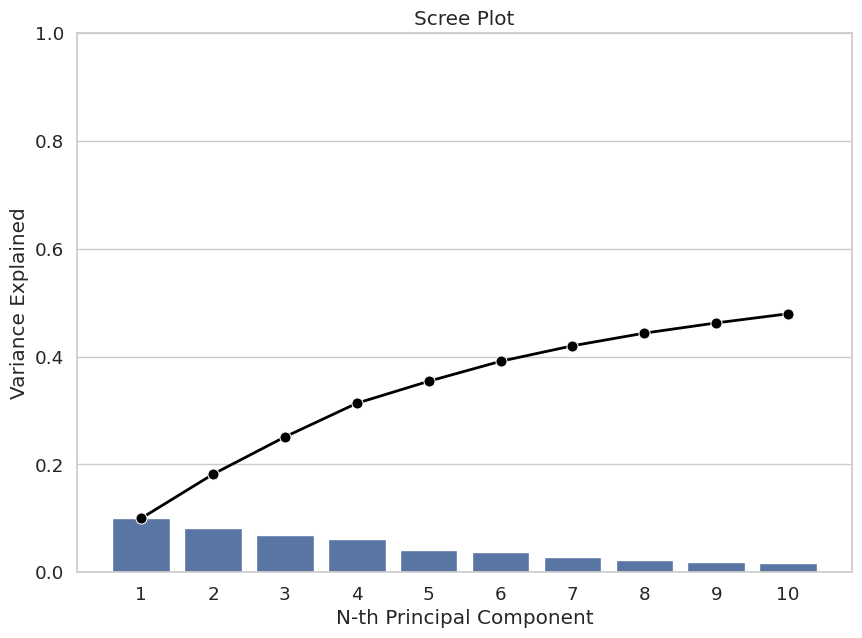

In [31]:
PC_components = np.arange(pcs.n_components_) + 1
#PC_components

_ = sns.set(style = 'whitegrid',
            font_scale = 1.2
            )

fig, ax = plt.subplots(figsize=(10, 7))

_ = sns.barplot(x = PC_components,
                y = pcs.explained_variance_ratio_,
                color = 'b'
                )

_ = sns.lineplot(x = PC_components-1,
                 y = np.cumsum(pcs.explained_variance_ratio_),
                 color = 'black',
                 linestyle = '-',
                 linewidth = 2,
                 marker = 'o',
                 markersize = 8
                 )

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()

La varianza en cada una de las componentes es mínima por lo que se requiere una cantidad realativamente alta de componentes para representar gran parte de la información, aún así, solo se estan tomano 10 componentes y estas solo representan el 48% de la varianza, es decir, se está perdiendo el 52% de la información.

In [32]:
# Convertir pcs_t a DataFrame
pcs_df = pd.DataFrame(pcs_t, columns=[f'PC{i+1}' for i in range(Dimensiones)])

# Verifica el resultado
print('Dimensiones del Frame de Datos Transformado: ',pcs_df.shape)
pcs_df.head()

Dimensiones del Frame de Datos Transformado:  (1023, 10)


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.755809 -4.031386  1.072941  3.485007 -0.188285 -3.830502 -2.263978   
1 -2.451658 -3.223795 -3.414214  1.894827 -2.082715 -2.458953 -2.831921   
2 -6.936300  1.758490 -2.600090 -0.811910  1.310882 -5.274036 -2.742110   
3  0.874404 -3.057926 -0.147964  4.636323 -0.469227 -4.478633 -2.447153   
4  0.750827 -1.763910 -4.399404 -0.986090 -2.731849 -1.561087 -6.283969   

        PC8       PC9      PC10  
0 -2.956204  4.865090 -1.868517  
1 -2.052599  2.976570 -1.890416  
2  1.243205  1.127966 -1.523201  
3 -0.636376  5.281762 -1.245080  
4 -2.059587  5.739870 -2.918607

In [33]:
pcs_df.describe()

PC1           PC2          PC3           PC4           PC5  \
count  1.023000e+03  1.023000e+03  1023.000000  1.023000e+03  1.023000e+03   
mean   1.111308e-16 -1.111308e-16     0.000000  5.556541e-17 -9.723948e-17   
std    6.294384e+00  5.699731e+00     5.238221  4.972520e+00  4.024517e+00   
min   -1.041637e+01 -1.258130e+01   -10.535472 -1.212338e+01 -1.009299e+01   
25%   -4.544503e+00 -3.751366e+00    -4.012932 -4.090490e+00 -2.380164e+00   
50%   -1.531449e+00 -3.654481e-01    -0.152013 -1.465406e-01  2.310671e-02   
75%    3.037652e+00  2.528127e+00     3.935836  3.665765e+00  2.446324e+00   
max    2.225510e+01  1.690168e+01    14.262094  1.338410e+01  1.203977e+01   

                PC6           PC7          PC8           PC9          PC10  
count  1.023000e+03  1.023000e+03  1023.000000  1.023000e+03  1.023000e+03  
mean  -1.111308e-16 -8.334812e-17     0.000000  1.666962e-16 -4.167406e-17  
std    3.830505e+00  3.374965e+00     3.053215  2.741330e+00  2.594864e+00  
min   -8.636623e+00 -9.492746e+00    -6.831057 -8.581284e+00 -5.941423e+00  
25%   -3.220740e+00 -2.308202e+00    -2.345535 -1.774492e+00 -1.895481e+00  
50%   -2.210264e-01 -7.055252e-02    -0.409710 -7.794682e-02 -1.501355e-01  
75%    2.883505e+00  2.006235e+00     1.844644  1.535483e+00  1.508242e+00  
max    9.154912e+00  9.928242e+00     9.133007  1.008581e+01  8.509703e+00

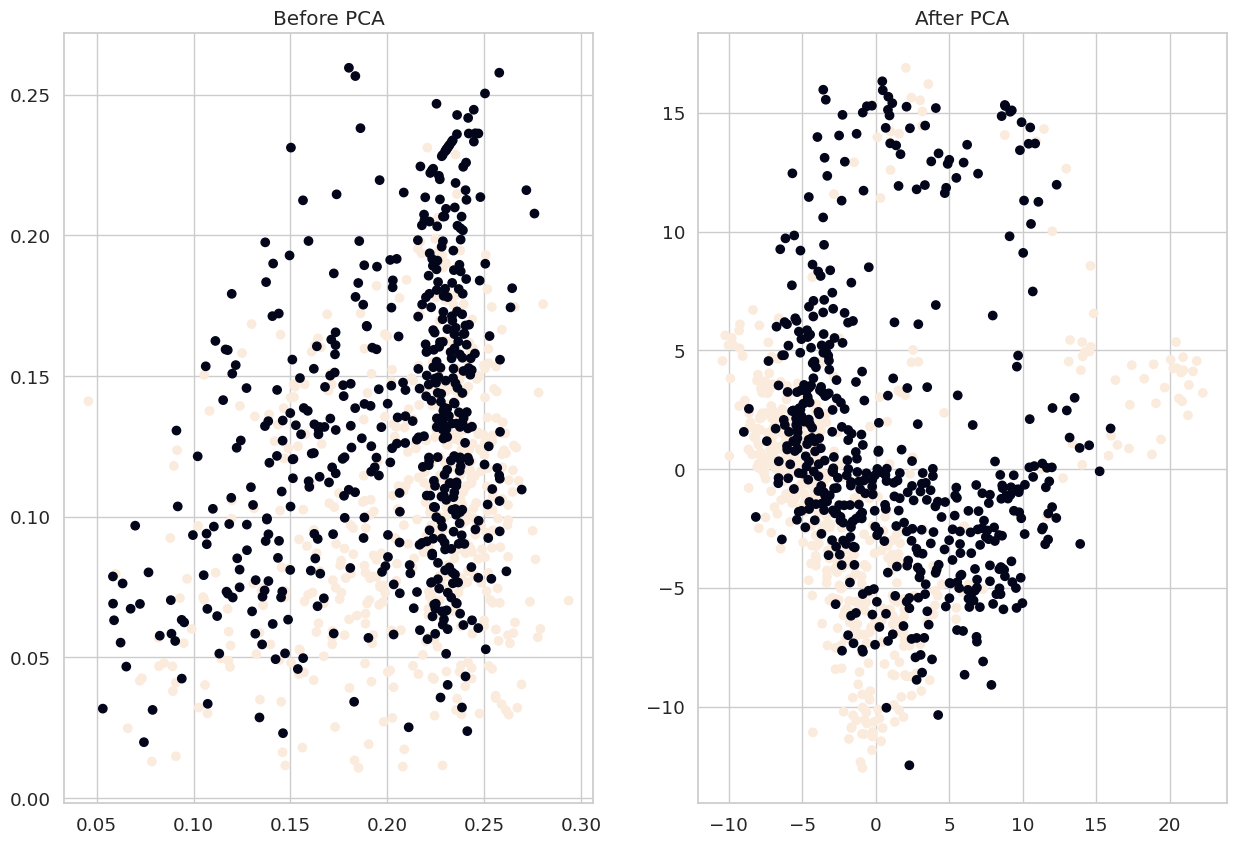

In [34]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(Xdf["X1"], Xdf["X2"], c=Ydf)
axes[0].set_title('Before PCA')
axes[1].scatter(pcs_df['PC1'], pcs_df['PC2'], c=Ydf)
axes[1].set_title('After PCA')
plt.show()

Se puede observar como despues de aplicar el PCA, utilizando las dos primeras componentes, aminora su varianza distribuyendose de mejor manera, si se visualizan demasiado juntas es debido a la cantidad de registros en el conjunto de datos.

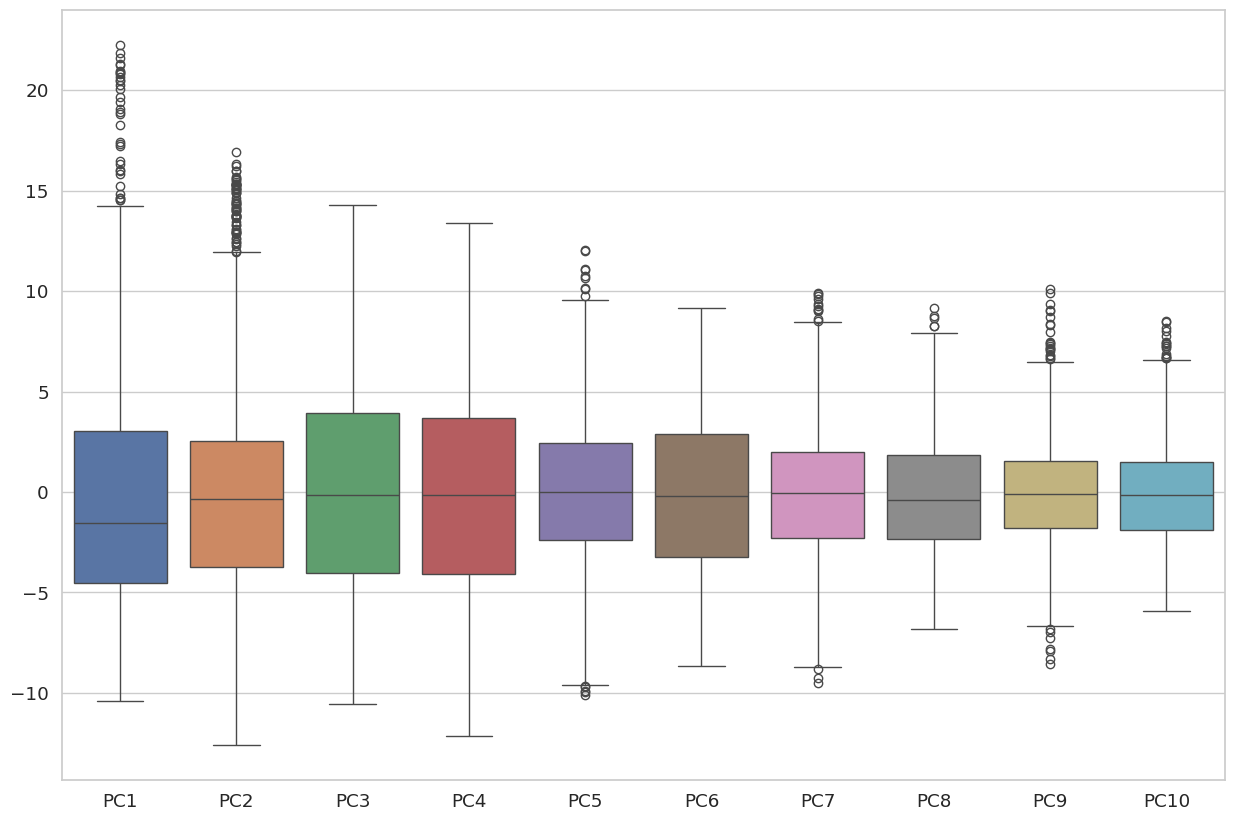

In [35]:
# Grafico de cajas
sns.boxplot(data = pcs_df, orient="v")
plt.show()

Al haber reducido las componentes, se puede presentar el gráfico de cajas y examinar los outliers del mismo, notando que son minimos

##### ***Importancia de las Variables de cada Componente***

In [36]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(),
                                columns=pcs_df.columns,
                                index=Xdf.columns
                                )
pcsComponents_df.round(3)

PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10
X1    0.011 -0.066 -0.083  0.007  0.014 -0.034  0.011  0.034 -0.015 -0.054
X2    0.037 -0.017 -0.049  0.043 -0.012 -0.034  0.021 -0.039 -0.093 -0.045
X3    0.016 -0.005  0.038 -0.020 -0.059 -0.002  0.044 -0.006 -0.085 -0.019
X4    0.034 -0.011  0.001 -0.008 -0.013  0.000  0.017 -0.082 -0.094 -0.011
X5    0.028 -0.008  0.037 -0.060  0.008  0.070 -0.014 -0.036 -0.032  0.033
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
X392 -0.053 -0.009 -0.033 -0.087 -0.008  0.013 -0.062 -0.048 -0.030  0.013
X393 -0.061 -0.002 -0.029 -0.071 -0.009  0.021 -0.049 -0.041 -0.034  0.011
X394 -0.044  0.005 -0.025 -0.076  0.007  0.012 -0.049  0.006 -0.032  0.016
X395 -0.048  0.014 -0.031 -0.092  0.020  0.014 -0.061 -0.022 -0.040 -0.005
X396 -0.033  0.017 -0.014 -0.083  0.023  0.008 -0.052 -0.027 -0.070 -0.051

[396 rows x 10 columns]

In [37]:
pcsComponents_df.PC1.abs().idxmax()

'X243'

In [38]:
pcsComponents_df.PC2.abs().idxmax()

'X182'

In [39]:
pcsComponents_df.PC3.abs().idxmax()

'X177'

---
## **Modelado**

### **Definición de Conjuntos de Entrenamiento, Validación y Prueba**

Consideraremos un $20\%$ de datos en el conjunto de prueba y dejaremos el resto, $80\%$, para utilizar en validación-cruzada.

In [40]:
Xtv, Xtest, ytv, ytest = train_test_split(pcs_df, Ydf, test_size=0.2, stratify=Ydf, random_state=1)

print(Xtv.shape, ': dimensión de datos de entrada para entrenamiento y validación')
print(Xtest.shape, ': dimensión de datos de entrada para prueba')

print(ytv.shape, ': dimensión de variable de salida para entrenamiento y validación')
print(ytest.shape, ': dimensión de variable de salida para prueba')

(818, 10) : dimensión de datos de entrada para entrenamiento y validación
(205, 10) : dimensión de datos de entrada para prueba
(818,) : dimensión de variable de salida para entrenamiento y validación
(205,) : dimensión de variable de salida para prueba


### **Definición de Métricas de Desempeño**

In [41]:
# Definiendo metodo para encontrar las metricas

def mis_metricas(yreal,ypred):
  vn,fp,fn,vp = confusion_matrix(yreal,ypred).ravel()
  accuracy = (vp+vn)/(vp+vn+fp+fn)
  f1score = (2*vp)/(2*vp+fp+fn)
  precision = vp/(vp+fp)
  recall = vp/(vp+fn)
  return accuracy, f1score, precision, recall

In [42]:
# Definiendo metodo para encontrar matriz de confusion

def mi_cm(yreal, ypred, name):

  cm = confusion_matrix(yreal, ypred)
  txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
  short = ["( VN )","( FP )","( FN )","( VP )"]
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(txt,short,frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize=(8,5))
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.title(name)
  plt.show()

In [43]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores, titulo):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq)
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores.
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')

    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')

    plt.title('Learning Curve - %s'%titulo)
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Exactitud (accuracy)')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [44]:
def get_CVandLC_scores(modelos):
  scores_allmodels = list()
  scores_names = ['ACCURACY', 'F1 SCORE', 'PRECISION', 'RECALL']
  lcurve_allmodels = list()
  for i in range(len(modelos)):

    #accuracy_list = list()
    #f1score_list = list()
    #precision_list = list()
    #recall_list = list()
    lcurve_onemodel = list()
    scores_onemodel = list()

    #pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
    pipeline = Pipeline(steps=[('m',modelos[i])])

    # Validacion Cruzada
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=0)
    scores = cross_validate(pipeline, Xtv, np.ravel(ytv), scoring=('accuracy','f1','precision','recall'), cv=cv, return_train_score=True)
    scores_onemodel.append(scores['test_accuracy'])
    scores_onemodel.append(scores['test_f1'])
    scores_onemodel.append(scores['test_precision'])
    scores_onemodel.append(scores['test_recall'])
    scores_allmodels.append(scores_onemodel)

    # Curva de Aprendizaje
    delta_train_sz = np.linspace(0.1, 1.0, 100)
    tr_sizes, tr_scores, val_scores = learning_curve(estimator = pipeline ,
                                                    X = Xtv,
                                                    y = ytv,
                                                    cv = cv,
                                                    train_sizes = delta_train_sz ,
                                                    random_state=11)
    lcurve_onemodel.append(tr_sizes)
    lcurve_onemodel.append(tr_scores)
    lcurve_onemodel.append(val_scores)
    lcurve_allmodels.append(lcurve_onemodel)

    #accuracy_list.append(scores_onemodel[0])
    #f1score_list.append(scores_onemodel[1])
    #precision_list.append(scores_onemodel[2])
    #recall_list.append(scores_onemodel[3])

  return scores_allmodels, scores_names, lcurve_allmodels

In [45]:
def show_metrics_summary(scores_ofmodels, model_names):
  for scores, nombre_modelo in zip(scores_ofmodels, model_names):
    print('Modelo: %s'%nombre_modelo)
    for score, name in zip(scores, scores_names):
      promedio = np.mean(score)*100
      desviacion = np.std(score)
      print('>> %s - Promedio: %.2f - Desviacion Estandar: %.3f'%(name,promedio,desviacion))
    print('\n')

In [46]:
def plot_LearningCurves(lcurve_ofmodels, model_names):
  qty = len(nombres)
  col = 3
  row = int(np.ceil(qty/col))
  #if qty == 1:
    #fig = plt.figure(figsize=(8,5))
  #else:
  fig = plt.figure(figsize=(20,row*5))
  fig.suptitle('Learning Curves')
  for i, (scores, nombre_modelo) in enumerate(zip(lcurve_ofmodels, model_names)):
    train_mean = np.mean(scores[1], axis=1)
    train_std = np.std(scores[1], axis=1)
    val_mean = np.mean(scores[2], axis=1)
    val_std = np.std(scores[2], axis=1)
    a = fig.add_subplot(row, col, i+1)
    a.plot(scores[0], train_mean, color='blue', marker='o', markersize=5, label='Training')
    a.fill_between(scores[0], train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    a.plot(scores[0], val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    a.fill_between(scores[0], val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    a.grid(True, which='both', linestyle='--', linewidth=0.5)
    a.legend(loc='lower left')
    a.set_title('Model: %s'%nombre_modelo)
    a.set_xlabel('Tamaño del conjunto de entrenamiento')
    a.set_ylabel('Exactitud (accuracy)')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta el layout para no solapar el título
  plt.show()

In [47]:
def plot_BoxplotsMetrics(scores_ofmodels, model_names):
  qty = len(nombres)
  col = 3
  row = int(np.ceil(qty/col))
  #if qty == 1:
    #fig = plt.figure(figsize=(8,5))
  #else:
  fig = plt.figure(figsize=(20,row*5))
  fig.suptitle('BOXPLOTS DE MÉTRICAS')
  for i, (scores, nombre_modelo) in enumerate(zip(scores_ofmodels, model_names)):
    a = fig.add_subplot(row, col, i+1)
    plt.boxplot(scores, labels=scores_names, showmeans=True)
    a.set_title(nombre_modelo)
    a.set_xlabel('METRICAS')
    a.set_ylabel('SCORE')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta el layout para no solapar el título
  plt.show()

### **Modelo de Referencia (Baseline)**

Se considera que el modelo base a utilizar en este problema de clasificación es Máquina de Vector Soporte.

Las máquinas de vectores de soporte (Support Vector Machines, SVM) son eficaces para la clasificación de imágenes debido a varias razones inherentes a su diseño y funcionamiento.

* Margen Máximo:

  SVM se enfoca en encontrar el hiperplano que maximiza el margen entre las clases de datos. Este enfoque de maximización del margen tiende a mejorar la capacidad de generalización del modelo, lo que es crucial cuando se trabaja con datos complejos como las imágenes.

* Capacidad para Manejar Altas Dimensiones:

  Las imágenes, cuando se representan en forma de datos, tienen una alta dimensionalidad (cada píxel es una dimensión). SVM es eficiente en espacios de alta dimensionalidad y puede manejar el gran número de características derivadas de imágenes.

* Kernels:

  SVM utiliza funciones kernel para transformar los datos en un espacio de mayor dimensión donde las clases sean más separables. El kernel más común para imágenes es el kernel radial (RBF), pero otros como el kernel polinómico o el kernel sigmoide también se pueden usar dependiendo de la naturaleza de los datos.
  Este enfoque permite a SVM manejar problemas no lineales al mapear los datos originales a un espacio donde un hiperplano lineal pueda separarlos.

* Eficiencia en Computación:

  SVM es eficiente en términos de memoria y computación, especialmente cuando se trata de conjuntos de datos grandes. Utiliza solo un subconjunto de puntos de datos (vectores de soporte) para definir el hiperplano de decisión, lo que reduce la complejidad computacional.

* Robustez a Sobreajuste (Overfitting):

  Dado que SVM busca el margen más amplio posible, tiende a ser menos propenso al sobreajuste en comparación con otros algoritmos, especialmente en conjuntos de datos con alta dimensionalidad como las imágenes.

* Regularización:

  SVM tiene un parámetro de regularización (C) que controla el equilibrio entre maximizar el margen y minimizar el error de clasificación en el conjunto de entrenamiento. Esto permite ajustar el modelo para obtener el mejor rendimiento en los datos de validación.


**Aplicación de SVM en Clasificación de Imágenes**

Algunos ejemplos de cómo SVM se puede aplicar en la clasificación de imágenes incluyen:

* Preprocesamiento de Imágenes:

  Las imágenes a menudo se preprocesan para extraer características relevantes antes de alimentarlas al SVM. Métodos como la transformación de Fourier, la transformada wavelet o el uso de descriptores de características (por ejemplo, HOG - Histogram of Oriented Gradients) son comunes.

* Clasificación Multiclase:

  SVM es un clasificador binario por naturaleza, pero se pueden usar técnicas como "one-vs-one" o "one-vs-all" para extenderlo a problemas de clasificación multiclase, que son comunes en tareas de clasificación de imágenes.

* Combinación con Otros Modelos:

  SVM a menudo se combina con otros modelos o técnicas, como redes neuronales convolucionales (CNN), donde SVM se usa como clasificador final sobre las características extraídas por la CNN.

In [48]:
def get_models():
  modelos = list()
  nombres = list()

  # SVM - Máquina de Vector Soporte:
  modelos.append(SVC(kernel='rbf',gamma='scale'))
  nombres.append('SVM')

  return modelos, nombres

#### ***Métricas***

In [49]:
modelos, nombres = get_models()  # cargamos los modelos a comparar

In [50]:
scores_ofmodels, scores_names, lcurve_ofmodels = get_CVandLC_scores(modelos)

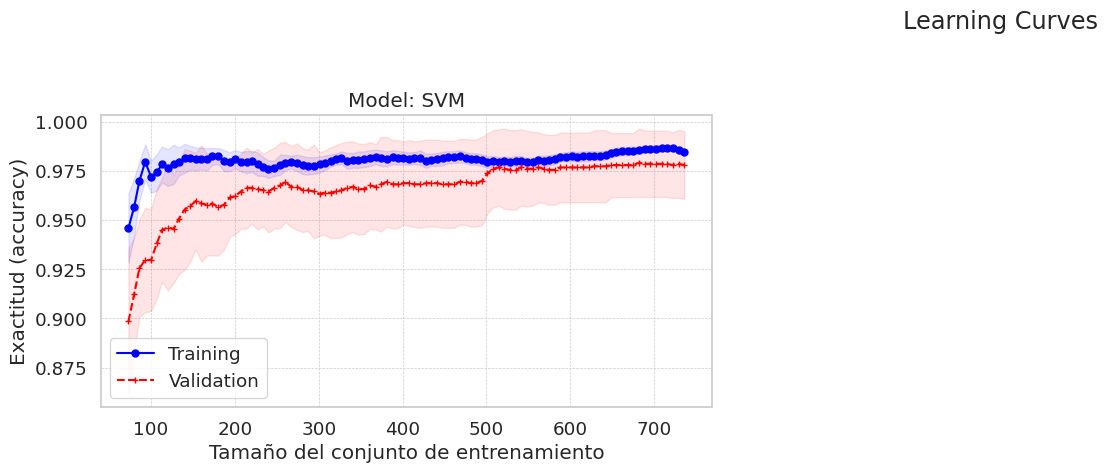

In [51]:
plot_LearningCurves(lcurve_ofmodels, nombres)

Interpretación de la Curva de Aprendizaje

Exactitud del Entrenamiento (línea azul sólida):

La exactitud del entrenamiento comienza alta, lo cual es esperado, ya que con pocos datos el modelo puede sobreajustarse fácilmente a los ejemplos disponibles.
A medida que el tamaño del conjunto de entrenamiento aumenta, la exactitud del entrenamiento disminuye ligeramente, estabilizándose alrededor del 98%. Esto indica que el modelo está aprendiendo a generalizar mejor y no simplemente memorizando los datos de entrenamiento.

Exactitud de Validación (línea roja discontinua):

La exactitud de validación comienza más baja, lo cual es típico, ya que con pocos datos de entrenamiento, el modelo no tiene suficiente información para generalizar bien a datos no vistos.
La exactitud de validación aumenta rápidamente con el incremento del tamaño del conjunto de entrenamiento, estabilizándose alrededor del 96-97%. Esto indica que el modelo mejora su capacidad de generalización con más datos de entrenamiento.

Convergencia de Exactitud:

Ambas curvas se estabilizan y comienzan a converger conforme aumenta el tamaño del conjunto de entrenamiento. La diferencia entre las curvas de entrenamiento y validación se reduce, lo cual es una señal positiva de que el modelo no está sobreajustando significativamente y está generalizando bien.
Sin embargo, siempre hay una pequeña brecha entre las curvas, lo cual es normal y muestra que hay un límite en la exactitud alcanzable con el modelo actual y los datos disponibles.

Variabilidad:

Las áreas sombreadas alrededor de las curvas representan la variabilidad en la exactitud (desviación estándar). La variabilidad disminuye a medida que el tamaño del conjunto de entrenamiento aumenta, indicando una mayor estabilidad en el rendimiento del modelo.

Conclusiones

Buen Rendimiento: El modelo SVM parece tener un buen rendimiento tanto en el conjunto de entrenamiento como en el de validación, con exactitudes superiores al 96%, lo cual es muy positivo.

Suficiencia de Datos: Dado que las curvas se estabilizan y convergen, parece que el conjunto de datos actual es suficiente para que el modelo alcance una buena generalización. Agregar más datos podría no resultar en mejoras significativas en la exactitud.

Posible Mejora: Si se desea mejorar aún más el rendimiento, podría ser útil explorar ajustes de hiperparámetros del SVM, experimentar con diferentes kernels, o mejorar la calidad de las características HOG extraídas de las imágenes.

No Sobreajuste: La diferencia reducida y estable entre las exactitudes de entrenamiento y validación sugiere que el modelo no está sobreajustando, lo cual es una buena señal de que el modelo es robusto.

En resumen, la curva de aprendizaje indica que el modelo SVM está funcionando bien y está bien generalizado para el conjunto de datos y características actuales.

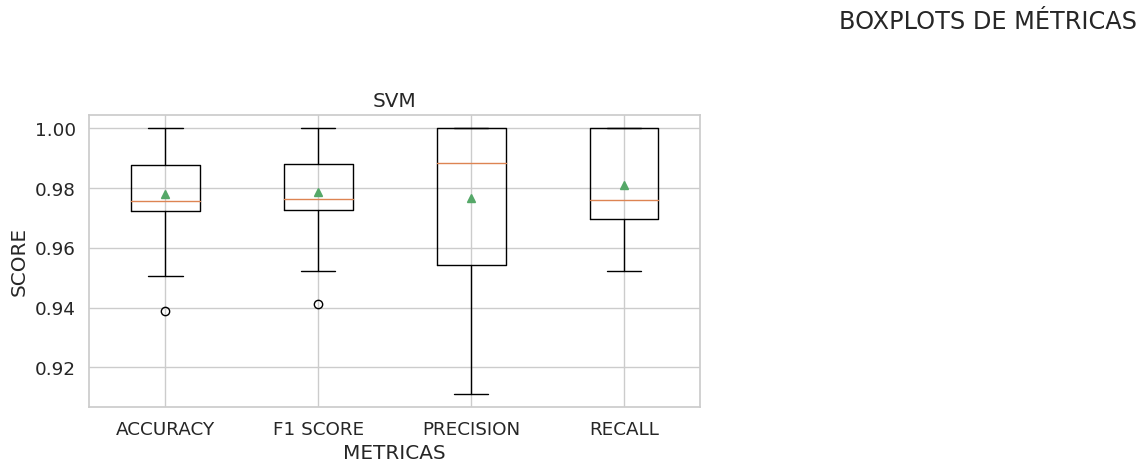

In [52]:
plot_BoxplotsMetrics(scores_ofmodels, nombres)

In [53]:
show_metrics_summary(scores_ofmodels, nombres)

Modelo: SVM
>> ACCURACY - Promedio: 97.80 - Desviacion Estandar: 0.017
>> F1 SCORE - Promedio: 97.86 - Desviacion Estandar: 0.017
>> PRECISION - Promedio: 97.69 - Desviacion Estandar: 0.028
>> RECALL - Promedio: 98.09 - Desviacion Estandar: 0.019




Dado que nuestro conjunto de datos contiene clases balanceadas, se puede utilizar cualquiera de las 4 métricas en el gráfico de cajas para evaluar el desempeño del modelo. El gráfico de cajas muestra los scores obtenidos de los conjuntos de prueba al realizar una validación cruzada, dando todas las métricas valores que rodan el 98%. Se considera tomar el accuracy como métrica de referencia.

Dada la complejidad de las características de este caso, que se tienen clases balanceadas y contemplando los resultados del modelo SVM, se considera una métrica de accuracy del 92% para los futuros modelos.

#### ***Feature Importance***

Feature: 0-PC1, 		Score: 0.07421
Feature: 1-PC2, 		Score: 0.10416
Feature: 2-PC3, 		Score: 0.04071
Feature: 3-PC4, 		Score: 0.04010
Feature: 4-PC5, 		Score: 0.01406
Feature: 5-PC6, 		Score: 0.04902
Feature: 6-PC7, 		Score: 0.00636
Feature: 7-PC8, 		Score: 0.12469
Feature: 8-PC9, 		Score: 0.11650
Feature: 9-PC10, 		Score: 0.00758


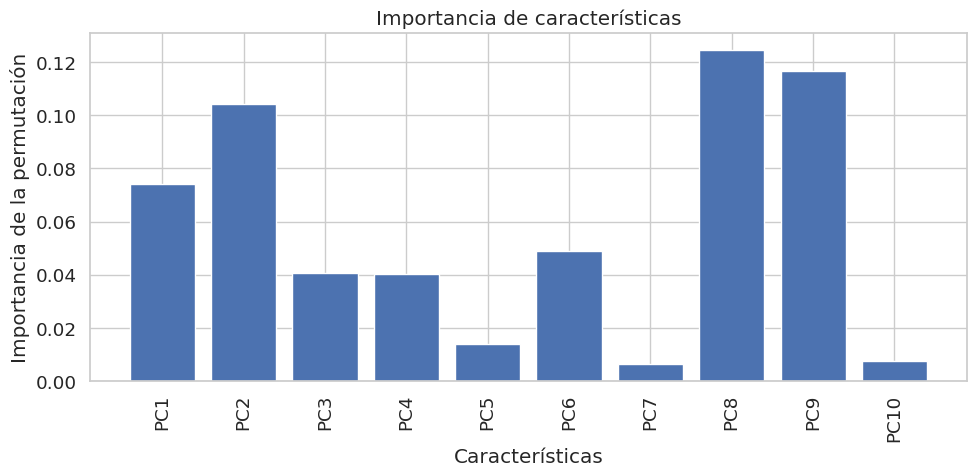

In [54]:
pipeline = Pipeline(steps=[('m',modelos[0])])

# Entrenamiento del Pipeline
pipeline.fit(Xtv,ytv)

importance = permutation_importance(pipeline, Xtv, ytv, n_repeats=10)

for i,v in enumerate(importance['importances_mean']):
	print('Feature: %d-%s, \t\tScore: %.5f' % (i,Xtv.columns[i],v))
plt.figure(figsize=(10, 5))
plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'])
plt.xlabel('Características')
plt.ylabel('Importancia de la permutación')
plt.title('Importancia de características')
plt.xticks(ticks=[x for x in range(len(importance['importances_mean']))], labels=Xtv.columns, rotation=90)
plt.tight_layout()  # Para ajustar el espacio y evitar solapamiento de etiquetas
plt.show()

### **Comparación de Modelos**

In [55]:
def get_models():
  modelos = list()
  nombres = list()

  # SVM - Máquina de Vector Soporte:
  modelos.append(SVC(kernel='rbf',gamma='scale'))
  nombres.append('SVM')

  # LR - Regresión Logística:
  modelos.append(LogisticRegression(solver='liblinear'))
  nombres.append('LR')

  # DM - Dummy
  modelos.append(DummyClassifier(strategy="stratified"))
  nombres.append('DM')

  # DT - Árbol de Decisión:
  modelos.append(DecisionTreeClassifier())
  nombres.append('DT')

  # MLP - Red Neuronal Artificial / Perceptrón Lineal Multicapa:
  modelos.append(MLPClassifier(hidden_layer_sizes=(20,), max_iter=3000))
  nombres.append('MLP')

  # kNN - k-Vecinos más cercanos:
  modelos.append(KNeighborsClassifier())
  nombres.append('kNN')

  return modelos, nombres

In [56]:
modelos, nombres = get_models()  # cargamos los modelos a comparar

In [57]:
scores_ofmodels, scores_names, lcurve_ofmodels = get_CVandLC_scores(modelos)

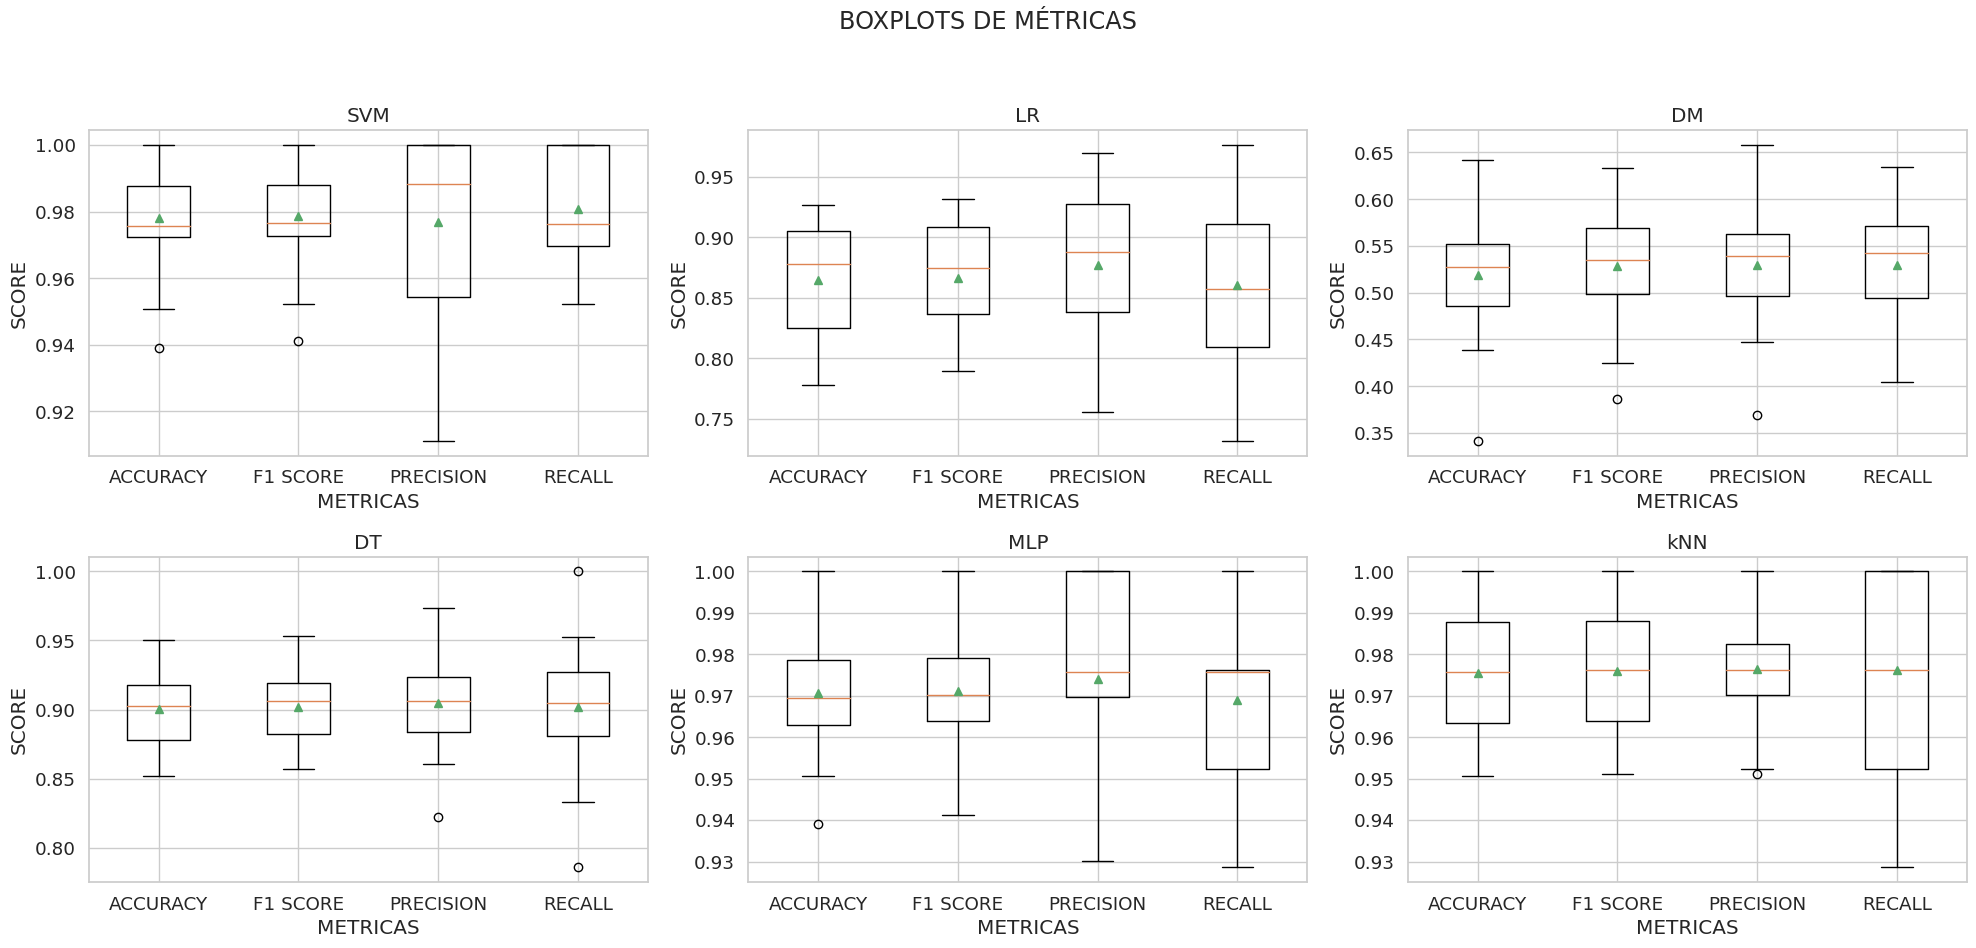

In [58]:
plot_BoxplotsMetrics(scores_ofmodels, nombres)

In [59]:
show_metrics_summary(scores_ofmodels, nombres)

Modelo: SVM
>> ACCURACY - Promedio: 97.80 - Desviacion Estandar: 0.017
>> F1 SCORE - Promedio: 97.86 - Desviacion Estandar: 0.017
>> PRECISION - Promedio: 97.69 - Desviacion Estandar: 0.028
>> RECALL - Promedio: 98.09 - Desviacion Estandar: 0.019


Modelo: LR
>> ACCURACY - Promedio: 86.49 - Desviacion Estandar: 0.047
>> F1 SCORE - Promedio: 86.63 - Desviacion Estandar: 0.047
>> PRECISION - Promedio: 87.72 - Desviacion Estandar: 0.064
>> RECALL - Promedio: 86.09 - Desviacion Estandar: 0.070


Modelo: DM
>> ACCURACY - Promedio: 51.90 - Desviacion Estandar: 0.065
>> F1 SCORE - Promedio: 52.88 - Desviacion Estandar: 0.061
>> PRECISION - Promedio: 52.94 - Desviacion Estandar: 0.062
>> RECALL - Promedio: 53.01 - Desviacion Estandar: 0.068


Modelo: DT
>> ACCURACY - Promedio: 90.04 - Desviacion Estandar: 0.025
>> F1 SCORE - Promedio: 90.20 - Desviacion Estandar: 0.025
>> PRECISION - Promedio: 90.45 - Desviacion Estandar: 0.035
>> RECALL - Promedio: 90.18 - Desviacion Estandar: 0.044


Modelo:

SVM y MLP tienen las métricas más altas y consistentes en general, con altos valores en Accuracy, F1 Score, y Precision. Ambos también muestran relativamente menos variabilidad.

kNN también muestra buenos resultados, pero con mayor variabilidad en Recall.

DT y LR presentan métricas moderadas y son menos consistentes que SVM y MLP.

DM es significativamente menos preciso y no se considera una buena opción.

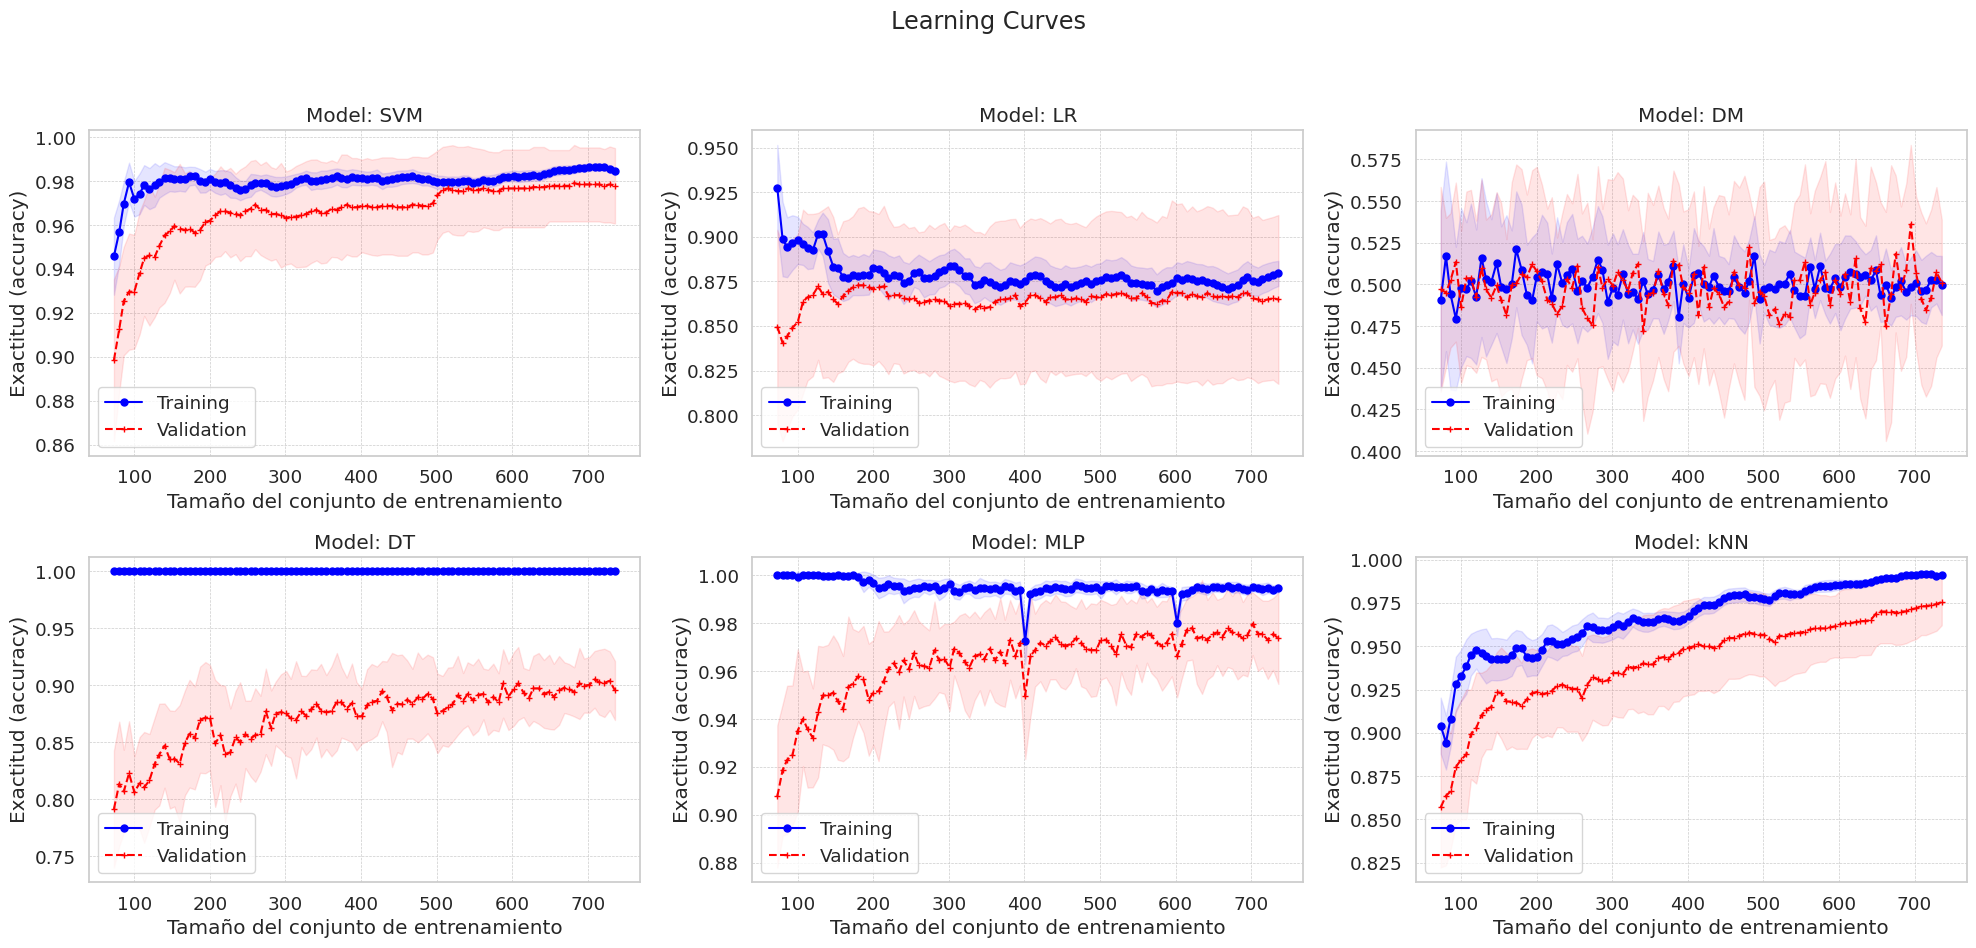

In [60]:
plot_LearningCurves(lcurve_ofmodels, nombres)

SVM (Support Vector Machine):

La precisión de entrenamiento es muy alta (cercana a 1.0) desde el principio.
La precisión de validación mejora con el aumento del tamaño del conjunto de entrenamiento, estabilizándose cerca de 0.97.
La diferencia entre las curvas de entrenamiento y validación es pequeña, lo que sugiere un buen ajuste sin sobreajuste significativo.

LR (Logistic Regression):

La precisión de entrenamiento comienza alta y disminuye ligeramente con el tamaño del conjunto de entrenamiento.
La precisión de validación es más baja y muestra una tendencia descendente, estabilizándose alrededor de 0.85-0.88.
Existe una brecha considerable entre las curvas de entrenamiento y validación, lo que sugiere que el modelo puede estar sobreajustado o insuficientemente ajustado para datos de validación.

DM (Dummy Model):

Tanto la precisión de entrenamiento como la de validación son bajas (alrededor de 0.50-0.55) y no muestran una mejora significativa con el aumento del tamaño del conjunto de entrenamiento.
Las curvas son inestables y muestran una gran variabilidad, indicando un desempeño pobre en general.

DT (Decision Tree):

La precisión de entrenamiento es perfecta (1.0), lo cual es típico de los árboles de decisión que tienden a sobreajustarse a los datos de entrenamiento.
La precisión de validación es significativamente menor y se estabiliza alrededor de 0.85-0.90.
La gran brecha entre las curvas de entrenamiento y validación indica un sobreajuste considerable.

MLP (Multilayer Perceptron):

La precisión de entrenamiento es alta y se estabiliza alrededor de 0.98-1.0.
La precisión de validación es ligeramente más baja, pero aún alta, alrededor de 0.95.
Las curvas están más cerca, indicando un buen balance entre el ajuste y la generalización, aunque hay pequeñas caídas en la curva de entrenamiento.

kNN (K-Nearest Neighbors):

La precisión de entrenamiento es alta y se estabiliza cerca de 0.97-0.98.
La precisión de validación mejora con el tamaño del conjunto de entrenamiento y se estabiliza alrededor de 0.95.
Las curvas son bastante cercanas, lo que sugiere un buen ajuste con un mínimo sobreajuste.

### **Modelos con Mejor Rendimiento**

El SVM y el MLP parecen ser los mejores modelos en función de las métricas presentadas, con SVM teniendo una ligera ventaja en consistencia.

Los dos mejores modelos, basados en las curvas de aprendizaje, son:

SVM (Support Vector Machine):

Muestra una alta precisión tanto en el conjunto de entrenamiento como en el de validación.
La diferencia entre las curvas de entrenamiento y validación es pequeña, lo que indica un buen ajuste sin sobreajuste significativo.

kNN (K-Nearest Neighbors):

Tiene una alta precisión de entrenamiento y validación.
Las curvas de entrenamiento y validación están bastante cerca, lo que sugiere que el modelo generaliza bien sin mucho sobreajuste.

Ambos modelos, SVM y kNN, muestran un buen desempeño y son capaces de generalizar bien a nuevos datos, haciéndolos las opciones más robustas entre los modelos presentados.

### **Búsqueda de Hiperparámetros (Fine Tuning)**

In [61]:
def get_hiperparametros(model_name, modelo, parametros):

  pipeline = Pipeline(steps = [('m',modelo)])
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=0)
  grid = GridSearchCV(
      estimator = pipeline,
      param_grid = parametros,
      cv = cv,
      refit = False,
      return_train_score = True
  )
  grid.fit(X = Xtv, y = np.ravel(ytv))
  print('Modelo: %s'%model_name)
  print('Best parameter (CV score = %0.3f):'%grid.best_score_)
  print(grid.best_params_)
  print('===========================================')

In [62]:
modelo_nombre = 'SVM'
modelo = SVC()
param_grid_svm = {
    #'m__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'm__kernel': ['rbf'],
    'm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    #'m__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'm__gamma': ['scale', 'auto'],
    'm__degree': [2, 3, 4]
}

In [63]:
get_hiperparametros(modelo_nombre, modelo, param_grid_svm)

Modelo: SVM
Best parameter (CV score = 0.983):
{'m__C': 10, 'm__degree': 2, 'm__gamma': 'scale', 'm__kernel': 'rbf'}


In [64]:
modelo_nombre = 'kNN'
modelo = KNeighborsClassifier()
param_grid_knn = {
    'm__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'm__weights': ['uniform', 'distance'],
    'm__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [65]:
get_hiperparametros(modelo_nombre, modelo, param_grid_knn)

Modelo: kNN
Best parameter (CV score = 0.983):
{'m__metric': 'manhattan', 'm__n_neighbors': 3, 'm__weights': 'distance'}


In [66]:
models = list()
models_names = list()

models.append(SVC(C = 10, degree = 2, gamma = 'scale', kernel = 'rbf'))
models_names.append('SVM')

models.append(KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, weights = 'distance'))
models_names.append('kNN')

In [67]:
scores_ofmodels, scores_names, lcurve_ofmodels = get_CVandLC_scores(models)

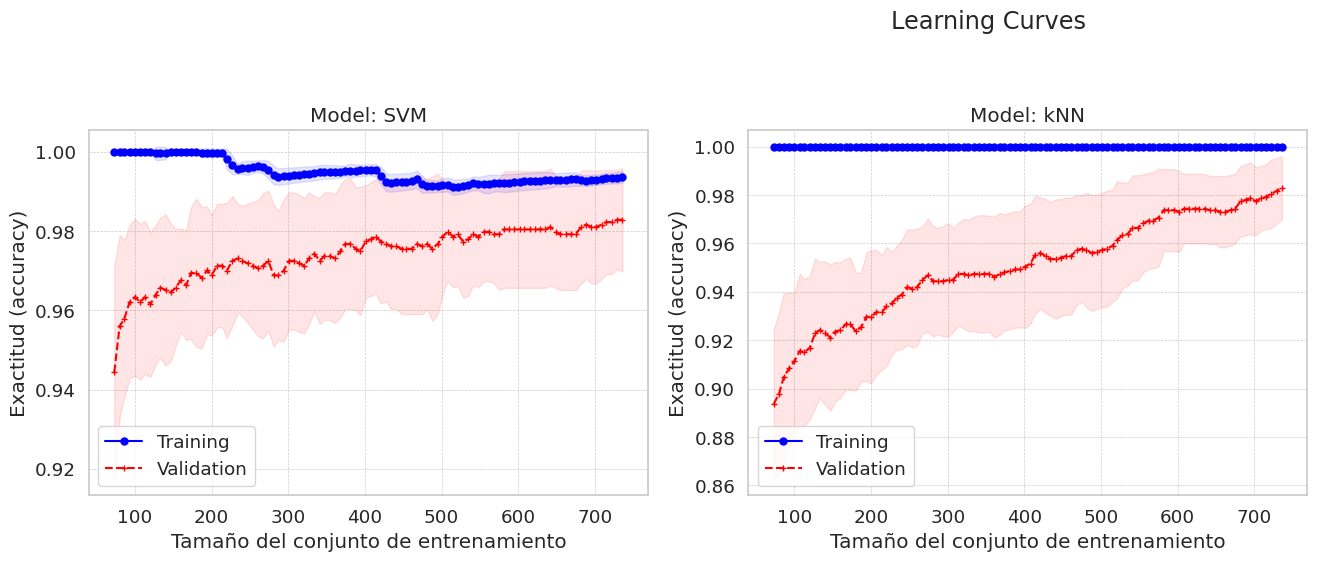

In [68]:
plot_LearningCurves(lcurve_ofmodels, models_names)

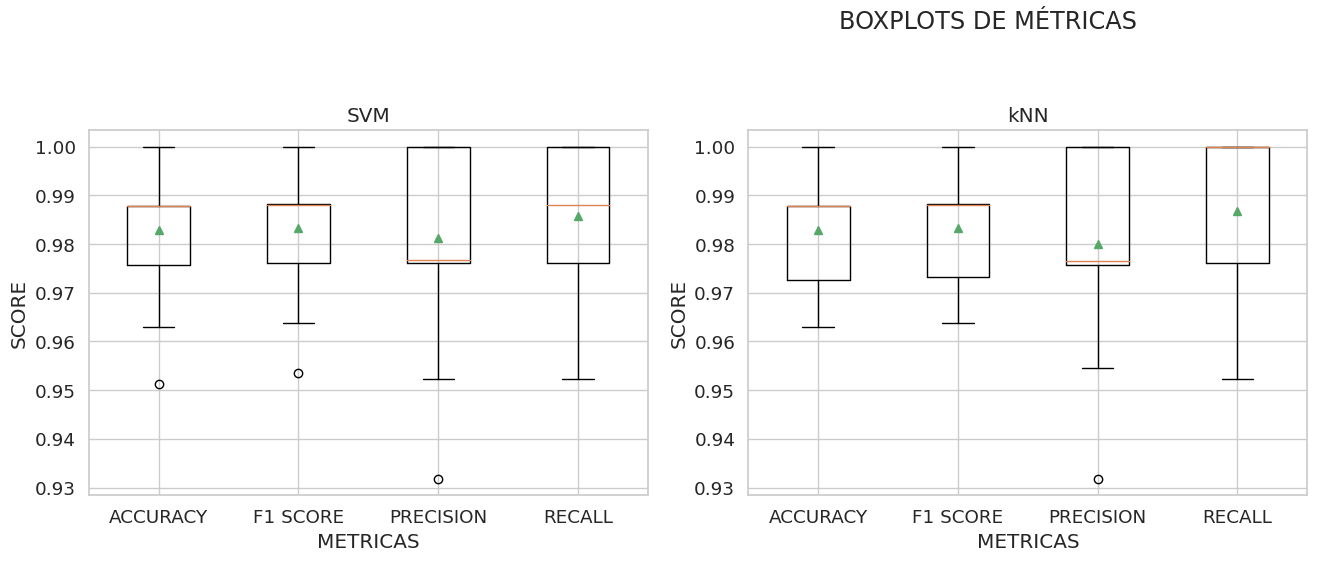

In [69]:
plot_BoxplotsMetrics(scores_ofmodels, models_names)

In [70]:
show_metrics_summary(scores_ofmodels, models_names)

Modelo: SVM
>> ACCURACY - Promedio: 98.29 - Desviacion Estandar: 0.013
>> F1 SCORE - Promedio: 98.33 - Desviacion Estandar: 0.013
>> PRECISION - Promedio: 98.12 - Desviacion Estandar: 0.019
>> RECALL - Promedio: 98.57 - Desviacion Estandar: 0.016


Modelo: kNN
>> ACCURACY - Promedio: 98.29 - Desviacion Estandar: 0.013
>> F1 SCORE - Promedio: 98.33 - Desviacion Estandar: 0.013
>> PRECISION - Promedio: 98.00 - Desviacion Estandar: 0.017
>> RECALL - Promedio: 98.69 - Desviacion Estandar: 0.019




Para determinar cuál es el mejor modelo entre SVM (Support Vector Machine) y k-NN (k-Nearest Neighbors) basándonos en las curvas de aprendizaje mostradas, podemos observar los siguientes aspectos:

**Exactitud (Accuracy) de Validación:**

* SVM: La exactitud de validación del SVM se estabiliza en torno a 0.96 y tiene una desviación estándar más baja en comparación con k-NN.
* k-NN: La exactitud de validación del k-NN empieza más baja y sube gradualmente hasta alrededor de 0.96, pero con una desviación estándar mayor.

**Desempeño General:**

* SVM: Muestra una curva de aprendizaje con menos variabilidad y una mejor estabilidad en la exactitud de validación.
* k-NN: Aunque mejora con el tamaño del conjunto de entrenamiento, muestra más variabilidad y una mayor diferencia inicial entre las curvas de entrenamiento y validación.

**Sobreajuste y Variabilidad:**

* SVM: Tiene una curva de entrenamiento que empieza alta y se mantiene cerca de 1.0, indicando un buen ajuste en los datos de entrenamiento sin signos evidentes de sobreajuste.
* k-NN: Presenta un mayor margen entre las curvas de entrenamiento y validación al inicio, lo cual puede indicar un sobreajuste inicial que se va corrigiendo a medida que aumenta el tamaño del conjunto de entrenamiento.

**Conclusión**

SVM (Support Vector Machine) parece ser el mejor modelo basado en las siguientes razones:

* Estabilidad en la Exactitud de Validación: La curva de validación es más estable y tiene una menor desviación estándar.
* Menor Variabilidad: SVM muestra menos variabilidad y una mejor estabilidad en su desempeño en comparación con k-NN.

Por lo tanto, SVM es el modelo recomendado entre los dos, ya que presenta un rendimiento más consistente y menos propenso a variaciones significativas.

### **Modelo Individual Final**

In [71]:
final_model = SVC(C = 10, degree = 2, gamma = 'scale', kernel = 'rbf')
pipeline = Pipeline(steps = [('m',final_model)])
pipeline.fit(Xtv, ytv)
yhat = pipeline.predict(Xtest)

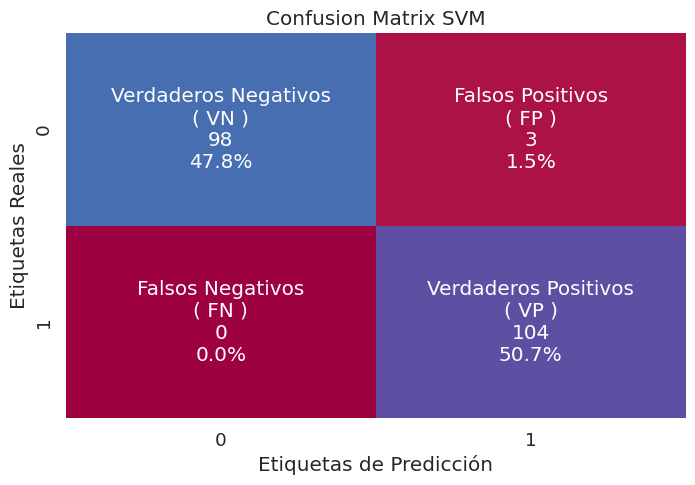

In [72]:
mi_cm(ytest, yhat, 'Confusion Matrix SVM')

In [73]:
accuracy, f1score, precision, recall = mis_metricas(ytest, yhat)
print('Modelo: SVM')
print('Accuracy: %0.3f'%accuracy)
print('F1 Score: %0.3f'%f1score)
print('Precision: %0.3f'%precision)
print('Recall: %0.3f'%recall)

Modelo: SVM
Accuracy: 0.985
F1 Score: 0.986
Precision: 0.972
Recall: 1.000


**Conclusiones**

* Alta Exactitud: Con una exactitud del 98.5%, el modelo tiene un desempeño muy alto en términos de la proporción de predicciones correctas sobre el total de predicciones.

* Perfecta Sensibilidad: La sensibilidad (recall) de 1.000 indica que el modelo es capaz de identificar correctamente todos los ejemplos positivos sin cometer ningún error de falsos negativos. Esto es especialmente importante en casos donde es crucial capturar todos los casos positivos.

* Alta Precisión: Con una precisión de 0.972, el modelo tiene una alta proporción de verdaderos positivos entre los positivos predichos, aunque no es perfecta. Esto significa que el modelo comete muy pocos errores de falsos positivos.

* Balance Entre Precision y Recall: El F1 Score de 0.986 sugiere un buen balance entre precisión y recall, lo que confirma que el modelo tiene un buen rendimiento tanto en capturar todos los positivos como en evitar falsos positivos.

**Interpretación de la Matriz de Confusión**

El modelo tiene una alta tasa de verdaderos positivos y verdaderos negativos, lo que sugiere que es efectivo tanto en identificar correctamente los ejemplos positivos como los negativos.

La presencia de 3 falsos positivos indica que en 3 casos, el modelo identificó incorrectamente ejemplos negativos como positivos.

La ausencia de falsos negativos es un indicador fuerte de la capacidad del modelo para detectar correctamente todos los ejemplos positivos.

**Conclusión Final**

El modelo SVM entrenado presenta un rendimiento excelente, con una alta exactitud y métricas muy favorables en términos de precisión, sensibilidad y F1 Score. La ausencia de falsos negativos y el bajo número de falsos positivos refuerzan la robustez del modelo para esta tarea de clasificación. Este modelo es confiable para aplicaciones donde es crítico identificar todos los ejemplos positivos y minimizar los errores de clasificación.

## **Evaluación**

TBD

## **Despliegue**

TBD

## **Monitoreo y Mantenimiento**

TBD

## **Bibliografía**

* Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O´Reilly Media. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/
* https://www.datacamp.com/es/tutorial/principal-component-analysis-in-python
* Jesús. (2020, 3 marzo). Cómo Extraer Features de una Imagen con HOG en Scikit-Image. DataSmarts Español. https://datasmarts.net/es/como-extraer-features-de-una-imagen-con-hog-en-scikit-image/
* Machine Learning con Python y Scikitlearn. (s. f.). https://cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn
* Máquinas de Vector Soporte (SVM) con Python. (s. f.). https://cienciadedatos.net/documentos/py24-svm-python
* PCA con Python. (s. f.). https://cienciadedatos.net/documentos/py19-pca-python.html
* Using OpenCV for Image Similarity. (2021, 26 noviembre). OpenCV. https://forum.opencv.org/t/using-opencv-for-image-similarity/6444
* 3.4. Curvas de validación: dibujar las puntuaciones para evaluar los modelos — documentación de scikit-learn - 0.24.1. (s. f.). https://qu4nt.github.io/sklearn-doc-es/modules/learning_curve.html
* Castellon, N. (2024, 16 marzo). Naren Castellon en LinkedIn: Una curva de aprendizaje en el aprendizaje automático es una. . .. https://es.linkedin.com/posts/naren-castellon-1541b8101_una-curva-de-aprendizaje-en-el-aprendizaje-activity-7174593484056621056-1-V8#:~:text=1%20mes-,Una%20curva%20de%20aprendizaje%20en%20el%20aprendizaje%20autom%C3%A1tico%20es%20una,del%20conjunto%20de%20entrenamiento%20aumenta.

## **Anexos**

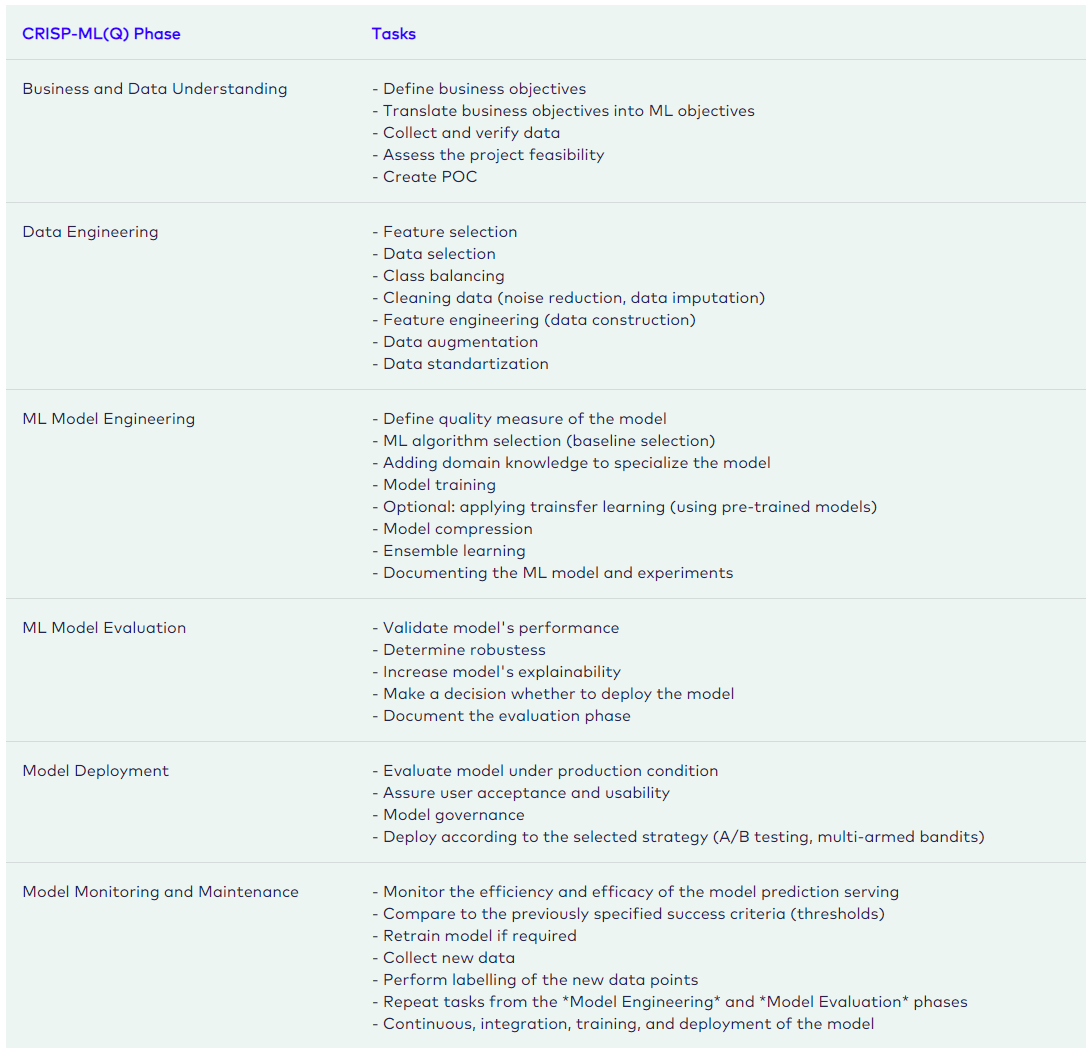

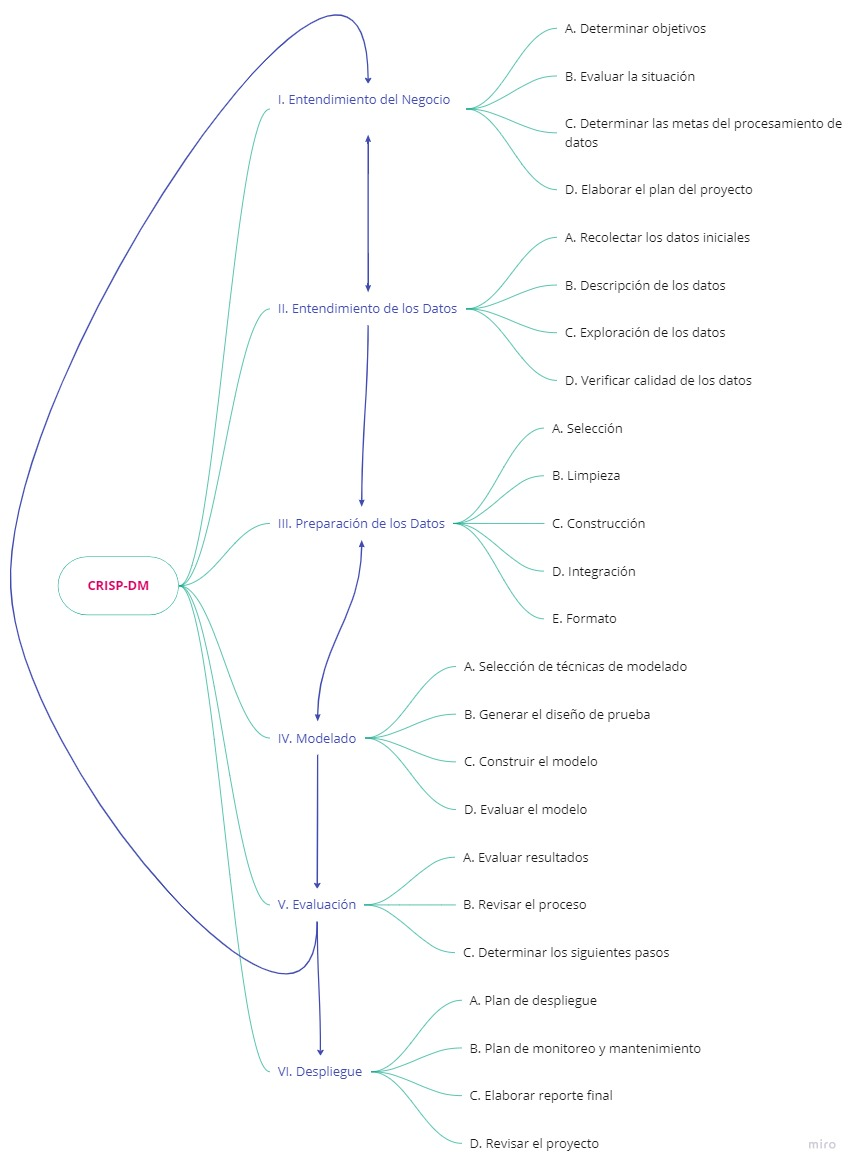

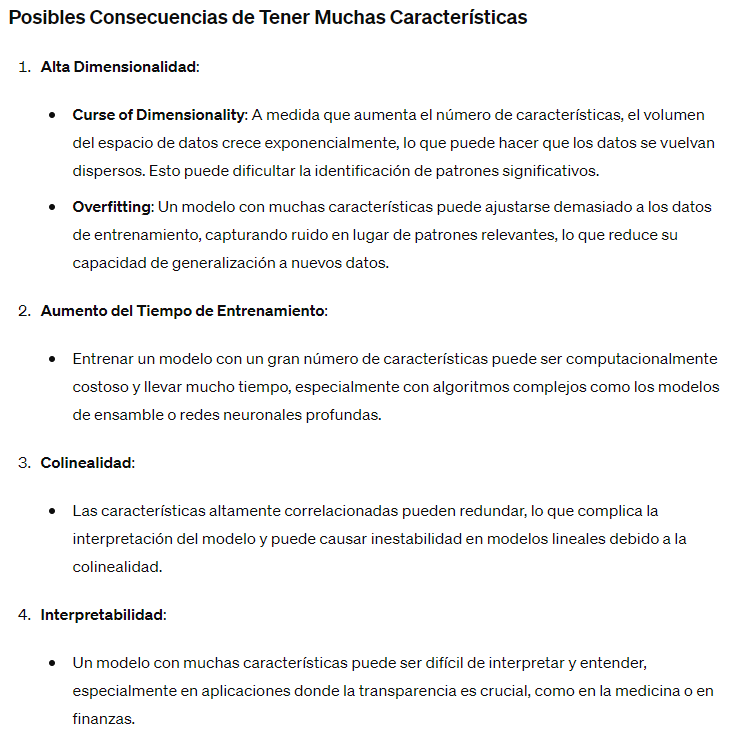

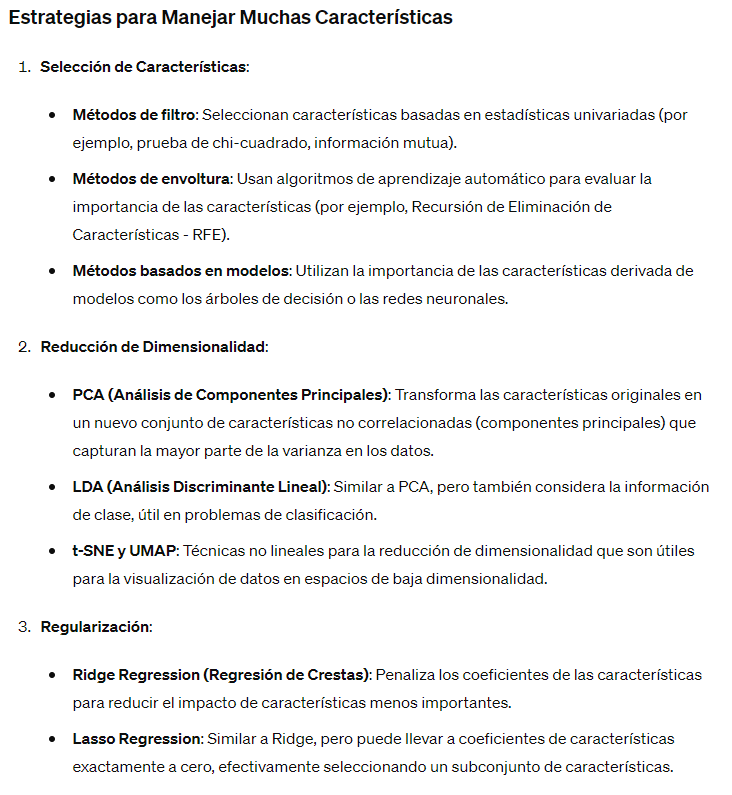

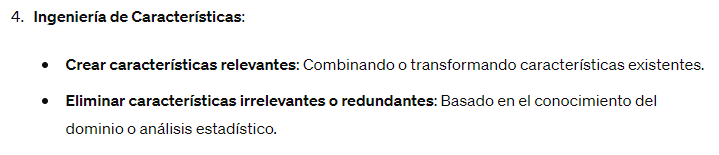

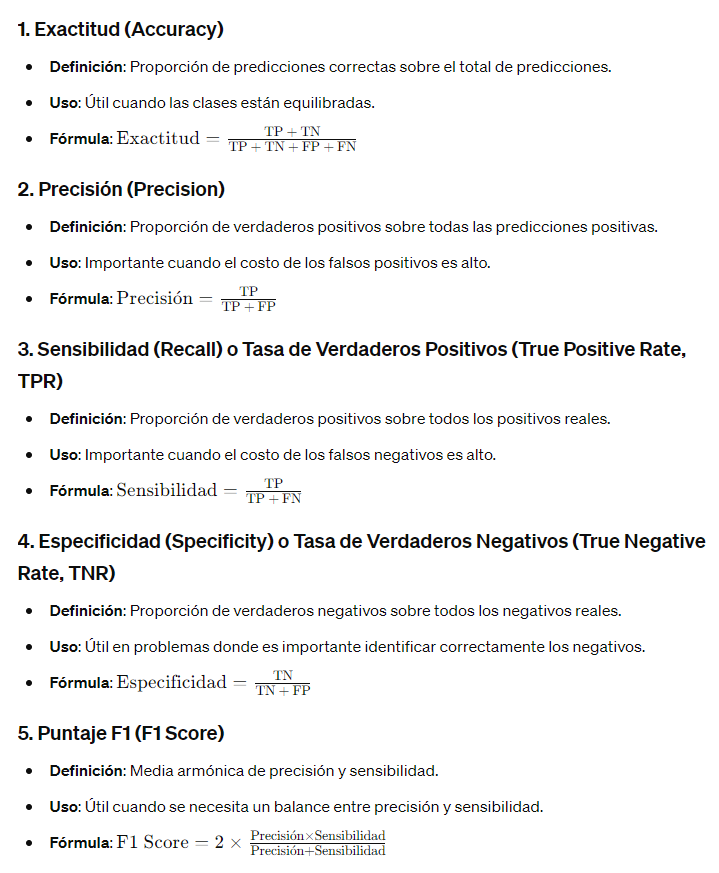

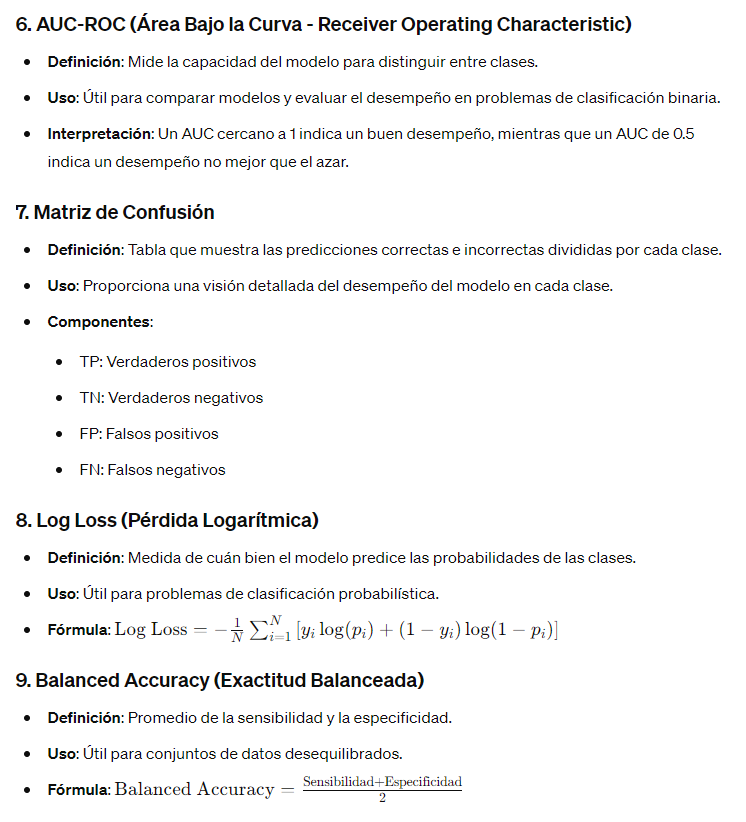

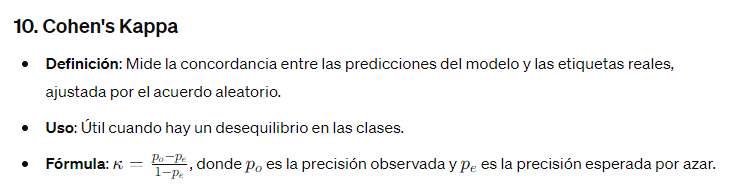